In [38]:
import polars as pl
import numpy as np
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

import ast
import math
import pickle
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, make_zscore_df
from bot.analysis.strategy_analysis import analyze_strategy, create_pair_trades_df
from bot.utils.coins import get_step_info, get_price_scale

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.utils.pair_trading import create_zscore_df, get_lr_zscore, get_dist_zscore, get_qty, round_down, calculate_profit_curve
from bot.utils.data import calculate_profit

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

In [39]:
trading_history = db_manager.get_table('trading_history', df_type='polars').filter(pl.col('mode') == 'real')

In [40]:
trading_history.sort(by='close_time')

shape: (31, 20)
┌─────────┬─────────┬──────────┬──────────┬───┬──────────┬─────────┬──────┬─────────┐
│ token_1 ┆ token_2 ┆ open_tim ┆ close_ti ┆ … ┆ pnl_2    ┆ profit  ┆ mode ┆ close_m │
│ ---     ┆ ---     ┆ e        ┆ me       ┆   ┆ ---      ┆ ---     ┆ ---  ┆ ode     │
│ str     ┆ str     ┆ ---      ┆ ---      ┆   ┆ f64      ┆ f64     ┆ str  ┆ ---     │
│         ┆         ┆ datetime ┆ datetime ┆   ┆          ┆         ┆      ┆ str     │
│         ┆         ┆ [μs, Eur ┆ [μs, Eur ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ ope/Mosc ┆ ope/Mosc ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ ow]      ┆ ow]      ┆   ┆          ┆         ┆      ┆         │
╞═════════╪═════════╪══════════╪══════════╪═══╪══════════╪═════════╪══════╪═════════╡
│ ARKM    ┆ STX     ┆ 2025-11- ┆ 2025-11- ┆ … ┆ 1.099289 ┆ 0.85311 ┆ real ┆ normal  │
│         ┆         ┆ 15       ┆ 16       ┆   ┆          ┆ 6       ┆      ┆         │
│         ┆         ┆ 19:23:15 ┆ 06:34:27 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ XRP     ┆ LDO     ┆ 2025-11- ┆ 2025-11- ┆ … ┆ 1.93015  ┆ 0.43904 ┆ real ┆ normal  │
│         ┆         ┆ 15       ┆ 16       ┆   ┆          ┆ 7       ┆      ┆         │
│         ┆         ┆ 21:20:25 ┆ 18:56:11 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ ARKM    ┆ ONDO    ┆ 2025-11- ┆ 2025-11- ┆ … ┆ -1.53332 ┆ 1.19671 ┆ real ┆ normal  │
│         ┆         ┆ 17       ┆ 18       ┆   ┆ 2        ┆ 7       ┆      ┆         │
│         ┆         ┆ 17:22:44 ┆ 11:35:42 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ DOT     ┆ RENDER  ┆ 2025-11- ┆ 2025-11- ┆ … ┆ -0.12913 ┆ 0.39755 ┆ real ┆ normal  │
│         ┆         ┆ 16       ┆ 18       ┆   ┆ 6        ┆ 83      ┆      ┆         │
│         ┆         ┆ 18:42:37 ┆ 20:00:06 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ ARKM    ┆ OP      ┆ 2025-11- ┆ 2025-11- ┆ … ┆ -2.52595 ┆ 2.83813 ┆ real ┆ normal  │
│         ┆         ┆ 18       ┆ 18       ┆   ┆ 9        ┆ 3       ┆      ┆         │
│         ┆         ┆ 13:00:15 ┆ 21:14:41 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ …       ┆ …       ┆ …        ┆ …        ┆ … ┆ …        ┆ …       ┆ …    ┆ …       │
│ GMT     ┆ KAS     ┆ 2025-11- ┆ 2025-11- ┆ … ┆ -40.0108 ┆ -40.234 ┆ real ┆ stop-lo │
│         ┆         ┆ 24       ┆ 26       ┆   ┆          ┆ 7       ┆      ┆ ss      │
│         ┆         ┆ 07:00:21 ┆ 22:25:55 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ ADA     ┆ ARB     ┆ 2025-11- ┆ 2025-11- ┆ … ┆ -0.61341 ┆ 0.68437 ┆ real ┆ normal  │
│         ┆         ┆ 24       ┆ 27       ┆   ┆ 6        ┆ 9       ┆      ┆         │
│         ┆         ┆ 21:26:36 ┆ 09:37:01 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ DOT     ┆ INJ     ┆ 2025-11- ┆ 2025-11- ┆ … ┆ -7.21654 ┆ -6.1630 ┆ real ┆ normal  │
│         ┆         ┆ 24       ┆ 27       ┆   ┆ 2        ┆ 43      ┆      ┆         │
│         ┆         ┆ 17:35:06 ┆ 10:11:44 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ SUI     ┆ TON     ┆ 2025-11- ┆ 2025-11- ┆ … ┆ 5.791251 ┆ 6.02501 ┆ real ┆ normal  │
│         ┆         ┆ 25       ┆ 27       ┆   ┆          ┆ 2       ┆      ┆         │
│         ┆         ┆ 06:02:12 ┆ 11:51:22 ┆   ┆          ┆         ┆      ┆         │
│         ┆         ┆ MSK      ┆ MSK      ┆   ┆          ┆         ┆      ┆         │
│ XRP     ┆ LDO     ┆ 2025-1

In [41]:
trading_history['profit'].sum(), trading_history['profit'].mean(), trading_history['profit'].std()

(-22.3739673, -0.7217408806451613, 8.396917872332118)

In [42]:
trading_history.group_by('token_1', 'token_2').agg(
    pl.col('profit').sum().round(2),
    pl.col('profit').min().round(2).alias('min_profit'),
    pl.col('profit').max().round(2).alias('max_profit'),
    (pl.col('profit').sum() / pl.col('profit').len()).round(2).alias('avg_profit'),
    pl.col('profit').len().alias('n_trades'),
).sort(by='n_trades', descending=True).head(10)

shape: (10, 7)
┌─────────┬─────────┬────────┬────────────┬────────────┬────────────┬──────────┐
│ token_1 ┆ token_2 ┆ profit ┆ min_profit ┆ max_profit ┆ avg_profit ┆ n_trades │
│ ---     ┆ ---     ┆ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---      │
│ str     ┆ str     ┆ f64    ┆ f64        ┆ f64        ┆ f64        ┆ u32      │
╞═════════╪═════════╪════════╪════════════╪════════════╪════════════╪══════════╡
│ XRP     ┆ LDO     ┆ -2.33  ┆ -4.68      ┆ 4.34       ┆ -0.58      ┆ 4        │
│ ARKM    ┆ OP      ┆ 1.76   ┆ -2.78      ┆ 2.84       ┆ 0.59       ┆ 3        │
│ CHZ     ┆ VET     ┆ -2.26  ┆ -1.24      ┆ -1.02      ┆ -1.13      ┆ 2        │
│ ARKM    ┆ ONDO    ┆ 2.42   ┆ 1.2        ┆ 1.22       ┆ 1.21       ┆ 2        │
│ GMT     ┆ BLUR    ┆ 1.58   ┆ -0.1       ┆ 1.68       ┆ 0.79       ┆ 2        │
│ ADA     ┆ ARB     ┆ 0.68   ┆ 0.68       ┆ 0.68       ┆ 0.68       ┆ 1        │
│ SUSHI   ┆ SEI     ┆ -5.19  ┆ -5.19      ┆ -5.19      ┆ -5.19      ┆ 1        │
│ GMT     ┆ KAS     ┆ -40.23 ┆ -40.23     ┆ -40.23     ┆ -40.23     ┆ 1        │
│ DYDX    ┆ ONDO    ┆ 1.86   ┆ 1.86       ┆ 1.86       ┆ 1.86       ┆ 1        │
│ ARKM    ┆ STX     ┆ 0.85   ┆ 0.85       ┆ 0.85       ┆ 0.85       ┆ 1        │
└─────────┴─────────┴────────┴────────────┴────────────┴────────────┴──────────┘

In [6]:
trading_history.group_by('side_1').agg(
    pl.col('profit').sum().round(2),
    pl.col('profit').min().round(2).alias('min_profit'),
    pl.col('profit').max().round(2).alias('max_profit'),
    (pl.col('profit').sum() / pl.col('profit').len()).round(2).alias('avg_profit'),
    pl.col('profit').len().alias('n_trades'),
).sort(by='profit', descending=True)

shape: (2, 6)
┌────────┬────────┬────────────┬────────────┬────────────┬──────────┐
│ side_1 ┆ profit ┆ min_profit ┆ max_profit ┆ avg_profit ┆ n_trades │
│ ---    ┆ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---      │
│ str    ┆ f64    ┆ f64        ┆ f64        ┆ f64        ┆ u32      │
╞════════╪════════╪════════════╪════════════╪════════════╪══════════╡
│ long   ┆ -5.56  ┆ -40.23     ┆ 9.09       ┆ -0.46      ┆ 12       │
│ short  ┆ -12.68 ┆ -12.15     ┆ 4.7        ┆ -0.85      ┆ 15       │
└────────┴────────┴────────────┴────────────┴────────────┴──────────┘

In [9]:
def get_profit_arr(tick_df, agg_df, token_1, token_2, side_1, side_2, open_time, open_price_1, open_price_2, 
                   qty_1, qty_2, qty_1_vol_long, qty_2_vol_long, qty_1_vol_short, qty_2_vol_short):
    temp_df = tick_df.filter(pl.col('time') >= open_time)
    
    time_arr = temp_df['time'].to_numpy()
    tss = temp_df['ts'].to_numpy()
    price1 = temp_df[token_1].to_numpy()
    price2 = temp_df[token_2].to_numpy()
    bid_1 = temp_df[f"{token_1}_bid_price"].to_numpy()
    ask_1 = temp_df[f"{token_1}_ask_price"].to_numpy()
    bid_2 = temp_df[f"{token_2}_bid_price"].to_numpy()
    ask_2 = temp_df[f"{token_2}_ask_price"].to_numpy()
    
    hist_ts = agg_df['ts'].to_numpy()
    hist_t1 = agg_df[token_1].to_numpy()
    hist_t2 = agg_df[token_2].to_numpy()

    nrows = tss.shape[0]
    t_arr = np.full(nrows, np.nan)
    ts_arr = np.full(nrows, np.nan)
    z_score_arr = np.full(nrows, np.nan)
    profit_usdt_arr = np.full(nrows, np.nan)
    profit_vnl_arr = np.full(nrows, np.nan)
    profit_vns_arr = np.full(nrows, np.nan)

    for i in range(nrows):
        t1_price = price1[i]
        t2_price = price2[i]
        close_price_1 = ask_1[i] if side_1 == 'short' else bid_1[i]
        close_price_2 = ask_2[i] if side_1 == 'long' else bid_2[i]
    
        # Выберем из агрегированных цен только те, которые были до текущего момента
        mask = hist_ts < tss[i]
        t1_hist = hist_t1[mask][-wind:]
        t2_hist = hist_t2[mask][-wind:]
    
        # Сформируем массивы, в которых к историческим данным в конец добавим текущую медианную цену, и посчитаем z_score
        t1_arr_med = np.append(t1_hist, t1_price)
        t2_arr_med = np.append(t2_hist, t2_price)
    
        _, _, zscore = get_dist_zscore(t1_arr_med, t2_arr_med, np.array([wind]))
        curr_profit_1 = calculate_profit(open_price_1, close_price_1, qty_1, side_1)
        curr_profit_2 = calculate_profit(open_price_2, close_price_2, qty_2, side_2)
        curr_profit = curr_profit_1 + curr_profit_2
    
        curr_profit_1_vl = calculate_profit(open_price_1, close_price_1, qty_1_vol_long, side_1)
        curr_profit_2_vl = calculate_profit(open_price_2, close_price_2, qty_2_vol_long, side_2)
        curr_profit_vl = curr_profit_1_vl + curr_profit_2_vl
    
        curr_profit_1_vs = calculate_profit(open_price_1, close_price_1, qty_1_vol_short, side_1)
        curr_profit_2_vs = calculate_profit(open_price_2, close_price_2, qty_2_vol_short, side_2)
        curr_profit_vs = curr_profit_1_vs + curr_profit_2_vs
        
        t_arr[i] = time_arr[i]
        ts_arr[i] = tss[i]
        z_score_arr[i] = zscore[0]
        profit_usdt_arr[i] = curr_profit
        profit_vnl_arr[i] = curr_profit_vl
        profit_vns_arr[i] = curr_profit_vs

    return time_arr, z_score_arr, profit_usdt_arr, profit_vnl_arr, profit_vns_arr

In [28]:
def create_report(token_1: str,
                  token_2: str,
                  tf: str,
                  wind: int,
                  thresh_in: float,
                  thresh_out: float,
                  open_time: datetime,
                  close_time: datetime,
                  spread_method: str,
                  min_order: int,
                  sl_usdt_ratio: float,
                  sl_std: float,
                  tp_ratio: float,
                  fee_rate: float,
                  coin_information: dict,
                  ):

    open_ts = int(datetime.timestamp(open_time))
    close_ts = int(datetime.timestamp(close_time))
    winds = np.array((wind, ))

    trading_history = db_manager.get_table('trading_history', df_type='polars')
    z_score_hist = db_manager.get_zscore_history(token_1 + '_USDT', token_2 + '_USDT', open_ts, close_ts)
    stats = pl.read_parquet('./data/pair_selection/all_pairs.parquet').filter(
                (pl.col('coin1') == token_1) & (pl.col('coin2') == token_2) | 
                (pl.col('coin1') == token_2) & (pl.col('coin2') == token_1)
            )
    data = trading_history.filter(
            (pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & 
            (abs(pl.col('open_time') - open_time) < timedelta(seconds=10))
        )

    side_1 = data['side_1'][0]
    side_2 = data['side_2'][0]
    leverage = int(data['leverage'][0])
    median_length = 6

    # Реальный размер позиции
    t1_qty = data['qty_1'][0]
    t2_qty = data['qty_2'][0]

    t1_op_real = data['open_price_1'][0]
    t2_op_real = data['open_price_2'][0]
    t1_cp_real = data['close_price_1'][0]
    t2_cp_real = data['close_price_2'][0]

    t1_profit = data['pnl_1'][0]
    t2_profit = data['pnl_2'][0]
    total_profit = t1_profit + t2_profit

    # vol-neutral (long-term std)
    total_pos_side = round(t1_qty * t1_op_real + t2_qty * t2_op_real)
    std_1 = stats['std_1'][0]
    std_2 = stats['std_2'][0]
    beta_1 = stats['beta_1'][0]
    beta_2 = stats['beta_2'][0]

    t1_qty_vn, t2_qty_vn = get_qty(token_1, token_2, t1_op_real, t2_op_real, beta=None, coin_information=coin_information,
                        total_usdt_amount=total_pos_side, fee_rate=fee_rate, std_1=std_1, std_2=std_2, method='vol_neutral')

    t1_profit_vn = calculate_profit(t1_op_real, t1_cp_real, t1_qty_vn, side_1)
    t2_profit_vn = calculate_profit(t2_op_real, t2_cp_real, t2_qty_vn, side_2)

    profit_vn = t1_profit_vn + t2_profit_vn

    # beta-neutral
    beta = stats['beta_2'][0]
    t1_qty_bn, t2_qty_bn = get_qty(token_1, token_2, t1_op_real, t2_op_real, beta, coin_information=coin_information,
                        total_usdt_amount=total_pos_side, fee_rate=fee_rate, method='beta_neutral')
    t1_profit_bn = calculate_profit(t1_op_real, t1_cp_real, t1_qty_bn, side_1)
    t2_profit_bn = calculate_profit(t2_op_real, t2_cp_real, t2_qty_bn, side_2)

    profit_bn = t1_profit_bn + t2_profit_bn

    if spread_method == 'lr':
        train_len = int(tf[0]) * wind * 2
    elif spread_method == 'dist':
        train_len = int(tf[0]) * wind
    start_time = open_time - timedelta(hours = train_len)

    
    pre_time = start_time - timedelta(hours=24)
    pre_1 = db_manager.get_tick_ob(token=token_1 + '_USDT', start_time=pre_time, end_time=open_time)
    pre_2 = db_manager.get_tick_ob(token=token_2 + '_USDT', start_time=pre_time, end_time=open_time)
    pre_avg_df = make_df_from_orderbooks(pre_1, pre_2, token_1, token_2, start_time=pre_time)
    pre_agg_df = make_trunc_df(pre_avg_df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')
    pre_tick_df = make_df_from_orderbooks(pre_1, pre_2, token_1, token_2, start_time=open_time-timedelta(hours=24))
    
    # График профита на предварительном датафрейме
    t1_pre = pre_tick_df[token_1][0]
    t2_pre = pre_tick_df[token_2][0]

    qty_1_pre, qty_2_pre = get_qty(token_1, token_2, t1_pre, t2_pre, None, coin_information,
                        total_pos_side, fee_rate, None, None, method='usdt_neutral')
    
    pre_t, pre_z_score, pre_usdt, _, _ = get_profit_arr(pre_tick_df, 
                pre_agg_df, token_1, token_2, side_1, side_2, pre_time, t1_pre, t2_pre, qty_1_pre, qty_2_pre,
                qty_1_pre, qty_2_pre, qty_1_pre, qty_2_pre)

    # Корреляция между движением z_score и движением профита 
    pre_z_arr = pre_z_score[~np.isnan(pre_z_score)]
    pre_pr_arr = pre_usdt[~np.isnan(pre_usdt)]
    pre_corr_usdt = np.corrcoef(pre_z_arr, pre_pr_arr)[0][1]

    # Чувствительность
    pre_dz = np.diff(pre_z_arr)
    pre_dvu = np.diff(pre_pr_arr)

    pre_mask = (np.abs(pre_dz) >= 0.0001) & (np.abs(pre_dvu) >= 0.0001)
    pre_mask_pos = (np.abs(pre_dz) >= 0.0001) & (np.abs(pre_dvu) >= 0.0001) & (pre_dz > 0)
    pre_mask_neg = (np.abs(pre_dz) >= 0.0001) & (np.abs(pre_dvu) >= 0.0001) & (pre_dz < 0)
    
    pre_dvu_dz = pre_dvu[pre_mask] / pre_dz[pre_mask]
    pre_dvu_dz_pos = pre_dvu[pre_mask_pos] / pre_dz[pre_mask_pos]
    pre_dvu_dz_neg = pre_dvu[pre_mask_neg] / pre_dz[pre_mask_neg]
    
    
    df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT', start_time=start_time, end_time=close_time)
    df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT', start_time=start_time, end_time=close_time)
    avg_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
    agg_df = make_trunc_df(avg_df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')
    tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
    spread_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, open_ts, median_length, 
                                 spr_method=spread_method)

    df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
         f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_2}_bid_price', f'{token_2}_ask_price',
         f'spread_mean_{wind}_{tf}', f'spread_std_{wind}_{tf}', f'z_score_{wind}_{tf}').filter(
            (pl.col('time') >= start_time) & (pl.col('time') <= close_time)
         ).rename({f'spread_mean_{wind}_{tf}': 'spread_mean', f'spread_std_{wind}_{tf}': 'spread_std', 
                   f'z_score_{wind}_{tf}': 'z_score'})

    fixed_spread = df['spread_mean'][0]
    fixed_std = df['spread_std'][0]

    df = df.with_columns(
        ((pl.col(token_1).log() - pl.col(token_2).log() - fixed_spread) / fixed_std).alias('fix_z_score')
    )

    # vol-neutral (long-term std)
    hist_df = agg_df.filter(pl.col('time') < open_time).tail(wind)

    vol_stats = hist_df.select([
            pl.col(token_1).diff().std().alias("vol_1"),
            pl.col(token_2).diff().std().alias("vol_2")
        ])
    std_1_vs = vol_stats["vol_1"][0]
    std_2_vs = vol_stats["vol_2"][0]

    t1_qty_vns, t2_qty_vns = get_qty(token_1, token_2, t1_op_real, t2_op_real, None, coin_information,
                        total_pos_side, fee_rate, std_1_vs, std_2_vs, method='vol_neutral')

    t1_profit_vns = calculate_profit(t1_op_real, t1_cp_real, t1_qty_vns, side_1)
    t2_profit_vns = calculate_profit(t2_op_real, t2_cp_real, t2_qty_vns, side_2)

    profit_vns = t1_profit_vns + t2_profit_vns

    # График профита
    t_arr, z_score_arr, profit_usdt_arr, profit_vnl_arr, profit_vns_arr = get_profit_arr(tick_df, 
                agg_df, token_1, token_2, side_1, side_2, open_time, t1_op_real, t2_op_real, t1_qty, t2_qty,
                t1_qty_vn, t2_qty_vn, t1_qty_vns, t2_qty_vns)

    # Корреляция между движением z_score и движением профита 
    z_arr = z_score_arr[~np.isnan(z_score_arr)]
    pr_arr = profit_usdt_arr[~np.isnan(profit_usdt_arr)]
    vnl_arr = profit_vnl_arr[~np.isnan(profit_vnl_arr)]
    vns_arr = profit_vns_arr[~np.isnan(profit_vns_arr)]
    
    corr_usdt = np.corrcoef(z_arr, pr_arr)[0][1]
    corr_vln = np.corrcoef(z_arr, vnl_arr)[0][1]
    corr_vsn = np.corrcoef(z_arr, vns_arr)[0][1]

    # Чувствительность
    dz = np.diff(z_score_arr)
    dvu = np.diff(profit_usdt_arr)
    dvnl = np.diff(profit_vnl_arr)
    dvns = np.diff(profit_vns_arr)

    mask = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001)
    mask_pos = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001) & (dz > 0)
    mask_neg = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001) & (dz < 0)
    
    dvu_dz = dvu[mask] / dz[mask]
    dvu_dz_pos = dvu[mask_pos] / dz[mask_pos]
    dvu_dz_neg = dvu[mask_neg] / dz[mask_neg]
    
    # stop-loss
    sl_profit = None
    if sl_usdt_ratio:
        pos_size = (t1_qty * t1_op_real + t2_qty * t2_op_real) / leverage
        sl_idx = z_score_hist.filter(pl.col('profit') < -sl_usdt_ratio * pos_size).head(1)

        if sl_idx.height > 0:
            sl_row = df.filter((m:=(pl.col('ts') - sl_idx['ts'][0]).abs()).min() == m)
            sl_time = sl_row['time'][0]
            t1_sl_close = sl_row[f'{token_1}_ask_price'][0] if side_1 == 'short' else sl_row[f'{token_1}_bid_price'][0]
            t2_sl_close = sl_row[f'{token_2}_bid_price'][0] if side_1 == 'short' else sl_row[f'{token_2}_ask_price'][0]

            sl_pr_1 = calculate_profit(open_price=t1_op_real, close_price=t1_sl_close, n_coins=t1_qty, side=side_1)
            sl_pr_2 = calculate_profit(open_price=t2_op_real, close_price=t2_sl_close, n_coins=t2_qty, side=side_2)
            sl_profit = sl_pr_1 + sl_pr_2

    slf_profit = None
    if sl_std:
        sl_idx = df.filter(abs(pl.col('fix_z_score')) > sl_std).head(1)

        if sl_idx.height > 0:
            slf_row = df.filter((m:=(pl.col('ts') - sl_idx['ts'][0]).abs()).min() == m)
            slf_time = slf_row['time'][0]
            t1_slf_close = slf_row[f'{token_1}_ask_price'][0] if side_1 == 'short' else slf_row[f'{token_1}_bid_price'][0]
            t2_slf_close = slf_row[f'{token_2}_bid_price'][0] if side_1 == 'short' else slf_row[f'{token_2}_ask_price'][0]

            slf_pr_1 = calculate_profit(open_price=t1_op_real, close_price=t1_slf_close, n_coins=t1_qty, side=side_1)
            slf_pr_2 = calculate_profit(open_price=t2_op_real, close_price=t2_slf_close, n_coins=t2_qty, side=side_2)
            slf_profit = slf_pr_1 + slf_pr_2

    # take-profit
    tp_profit = None
    if tp_ratio:
        pos_size = (t1_qty * t1_op_real + t2_qty * t2_op_real) / leverage
        tp_idx = z_score_hist.filter(pl.col('profit') > tp_ratio * pos_size).head(1)

        if tp_idx.height > 0:
            tp_row = df.filter((m:=(pl.col('ts') - tp_idx['ts'][0]).abs()).min() == m)
            tp_time = tp_row['time'][0]
            t1_tp_close = tp_row[f'{token_1}_ask_price'][0] if side_1 == 'short' else tp_row[f'{token_1}_bid_price'][0]
            t2_tp_close = tp_row[f'{token_2}_bid_price'][0] if side_1 == 'short' else tp_row[f'{token_2}_ask_price'][0]

            tp_pr_1 = calculate_profit(open_price=t1_op_real, close_price=t1_tp_close, n_coins=t1_qty, side=side_1)
            tp_pr_2 = calculate_profit(open_price=t2_op_real, close_price=t2_tp_close, n_coins=t2_qty, side=side_2)
            tp_profit = tp_pr_1 + tp_pr_2

    coef = df[token_1].mean() / df[token_2].mean()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

    # --- Графики цены ---
    ax1.plot(df.select('time'), df.select(token_1), label=token_1, color='orange')
    ax1.set_title(f'{token_1} - {token_2} (tf: {tf}, wind: {wind}, side: {side_1}; thresh_in: {thresh_in}, thresh_out: {thresh_out})')
    ax1.set_ylabel('udst')
    ax1.legend()
    ax1.grid()

    ax4 = ax1.twinx()
    ax4.plot(df.select('time'), df.select(token_2), label=token_2, color='blue')

    # --- Графики z_score ---
    ax2.plot(df.select('time'), df.select('z_score'), label='calc', c='green')
    ax2.plot(df.select('time'), df.select('fix_z_score'), label='fixed', c='gray')
    ax2.plot(z_score_hist.select('time'), z_score_hist.select('z_score'), label=f'real')
    ax2.set_ylabel('z_score')
    if side_1 == 'long':
        ax2.axhline(-thresh_in, c='g', linestyle='dotted')
        ax2.axhline(thresh_out, c='r', linestyle='dotted')
    else:
        ax2.axhline(thresh_in, c='g', linestyle='dotted')
        ax2.axhline(-thresh_out, c='r', linestyle='dotted')
    ax2.grid()
    ax2.legend()

    # --- График профита ---
    ax3.plot(z_score_hist.select('time'), z_score_hist.select('profit'), color='green', label='usdt_neutral')
    ax3.plot(t_arr, profit_vnl_arr, color='red', label='vol_neutral long')
    ax3.plot(t_arr, profit_vns_arr, color='blue', label='vol_neutral short')
    ax3.set_ylabel('profit')
    ax3.grid()
    ax3.legend()

    plt.tight_layout()
    plt.show()

    print(f'{token_1} - {token_2}. Side: {side_1}; Timeframe: {tf}; window: {wind}; thresh_in: {thresh_in}, thresh_out: {thresh_out}')
    print(f'[ OPEN] Время: {open_time:%Y-%m-%d %H:%M:%S}; Цены. {token_1}: {t1_op_real}; {token_2}: {t2_op_real};', end=' ')
    print(f'z_score: {z_score_hist['z_score'][0]:.2f}')
    print(f'Волатильность. (long): {token_1}: {std_1:.4f}, {token_2}: {std_2:.4f}; (short): {token_1}: {std_1_vs:.4f}, {token_2}: {std_2_vs:.4f}')
    print(f'std_ratio (long): {std_1 / std_2:.4f}; std_ratio (short): {std_1_vs / std_2_vs:.4f}')
    print(f'Коэффициент хеджирования beta. beta_1: {beta_1:.3f}, beta_2: {beta_2:.3f}')
    print(f'Корреляция в предыдущие сутки: {pre_corr_usdt:.2f}')
    print(f'Чувствительность в предыдущие сутки: Общая: {np.mean(pre_dvu_dz):.2f}; Pos: {np.mean(pre_dvu_dz_pos):.2f}; Neg: {np.mean(pre_dvu_dz_neg):.2f}')
    print(f'[CLOSE] Время: {close_time:%Y-%m-%d %H:%M:%S}; Цены. {token_1}: {t1_cp_real}; {token_2}: {t2_cp_real}; z_score: {z_score_hist['z_score'][-1]:.2f}')
    print(f'Corr. Usdt: {corr_usdt:.2f}; Vol-neut short: {corr_vsn:.2f}; Vol-neut long: {corr_vln:.2f}')
    print(f'Чувствительность. Общая: {np.mean(dvu_dz):.2f}; Pos: {np.mean(dvu_dz_pos):.2f}; Neg: {np.mean(dvu_dz_neg):.2f}')
    
    print()
    print(f'[PROFIT]')
    print(f'usdt-neutral     : {t1_qty} {token_1}({side_1}): {t1_profit:.2f}$, {t2_qty} {token_2}({side_2}): {t2_profit:.2f}$; total profit: {total_profit:.2f}$')
    print(f'vol-neutral long : {t1_qty_vn} {token_1}({side_1}): {t1_profit_vn:.2f}$, {t2_qty_vn} {token_2}({side_2}): {t2_profit_vn:.2f}$; total profit: {profit_vn:.2f}$')
    print(f'vol-neutral short: {t1_qty_vns} {token_1}({side_1}): {t1_profit_vns:.2f}$, {t2_qty_vns} {token_2}({side_2}): {t2_profit_vns:.2f}$; total profit: {profit_vns:.2f}$')
    print(f'beta-neutral: {t1_qty_bn} {token_1}({side_1}): {t1_profit_bn:.2f}$, {t2_qty_bn} {token_2}({side_2}): {t2_profit_bn:.2f}$; total profit: {profit_bn:.2f}$')

    if sl_profit:
        print(f'\n[STOP LOSS] Время создания ордера: {sl_time:%Y-%m-%d %H:%M:%S}')
        print(f'Цены. {token_1}: {t1_sl_close}; {token_2}: {t2_sl_close}')
        print(f'Profit: {token_1}({side_1}): {sl_pr_1:.2f}$, {token_2}({side_2}): {sl_pr_2:.2f}$; total profit: {sl_profit:.2f}$')
    if slf_profit:
        print(f'\n[STOP LOSS] Время создания ордера: {slf_time:%Y-%m-%d %H:%M:%S}')
        print(f'Цены. {token_1}: {t1_slf_close}; {token_2}: {t2_slf_close}')
        print(f'Profit: {token_1}({side_1}): {slf_pr_1:.2f}$, {token_2}({side_2}): {slf_pr_2:.2f}$; total profit: {slf_profit:.2f}$')

    if tp_profit:
        print(f'\n[TAKE PROFIT] Время создания ордера: {tp_time:%Y-%m-%d %H:%M:%S}')
        print(f'Цены. {token_1}: {t1_tp_close}; {token_2}: {t2_tp_close}')
        print(f'Profit: {token_1}({side_1}): {tp_pr_1:.2f}$, {token_2}({side_2}): {tp_pr_2:.2f}$; total profit: {tp_profit:.2f}$')

    return total_profit, profit_vn, profit_vns, sl_profit, slf_profit, tp_profit

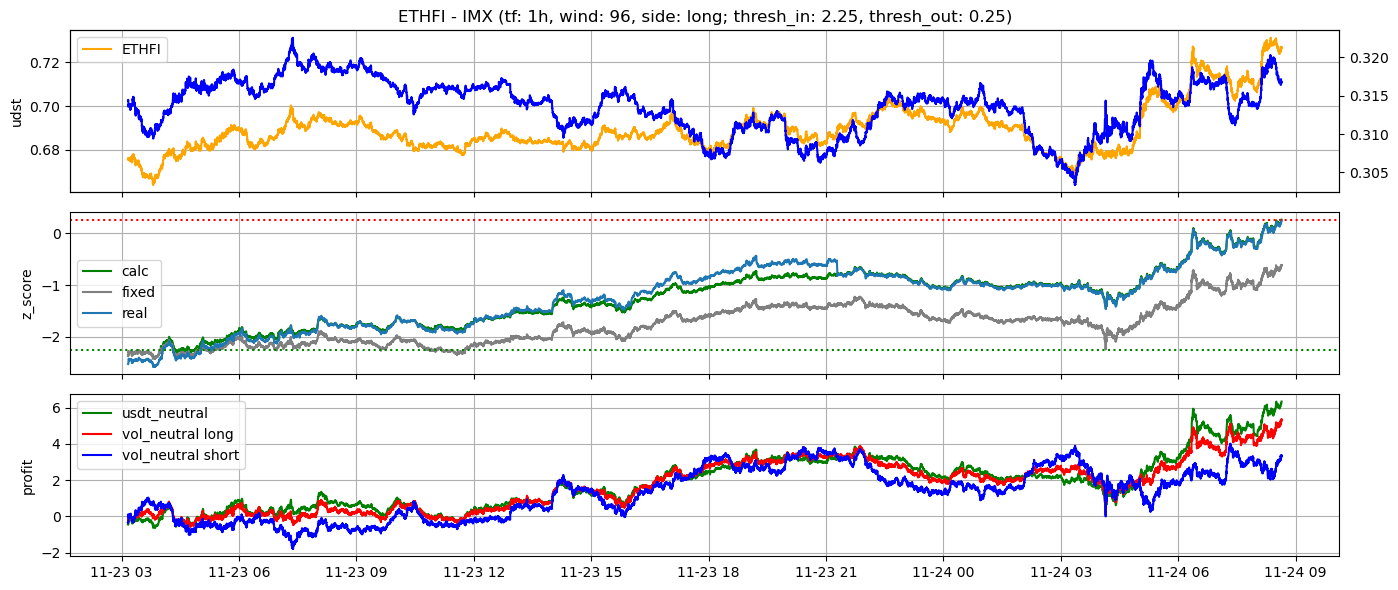

ETHFI - IMX. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-23 03:09:50; Цены. ETHFI: 0.6756; IMX: 0.3143; z_score: -2.52
Волатильность. (long): ETHFI: 0.0784, IMX: 0.0591; (short): ETHFI: 0.0089, IMX: 0.0040
std_ratio (long): 1.3271; std_ratio (short): 2.2195
Коэффициент хеджирования beta. beta_1: 0.628, beta_2: 1.401
Корреляция в предыдущие сутки: 0.74
Чувствительность в предыдущие сутки: Общая: 3.09; Pos: 3.04; Neg: 3.13
[CLOSE] Время: 2025-11-24 08:38:28; Цены. ETHFI: 0.7268561; IMX: 0.3167; z_score: 0.24
Corr. Usdt: 0.98; Vol-neut short: 0.83; Vol-neut long: 0.96
Чувствительность. Общая: 4.38; Pos: 4.43; Neg: 4.32

[PROFIT]
usdt-neutral     : 147.6 ETHFI(long): 7.39$, 317.8 IMX(short): -0.93$; total profit: 6.46$
vol-neutral long : 126.9 ETHFI(long): 6.41$, 362.0 IMX(short): -0.99$; total profit: 5.41$
vol-neutral short: 91.7 ETHFI(long): 4.63$, 437.7 IMX(short): -1.20$; total profit: 3.43$
beta-neutral: 179.0 ETHFI(long): 9.04$, 25

In [29]:
#  "	""	 MSK	

token_1 = 'ETHFI'
token_2 = 'IMX'
start_time = "2025-11-23 03:09:50"
end_time = "2025-11-24 08:38:28"
tf = '1h'
wind = 96
thresh_in = 2.25
thresh_out = 0.25

open_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))
close_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))

profit, profit_vnl, profit_vns, sl_profit, slf_profit, tp_profit = create_report(token_1, token_2, tf, wind, thresh_in, thresh_out, 
            open_time, close_time, spread_method='dist',
            sl_usdt_ratio=0.1, sl_std=5.0, tp_ratio=0.2, fee_rate=0.00055, coin_information=coin_information,
            min_order=40)

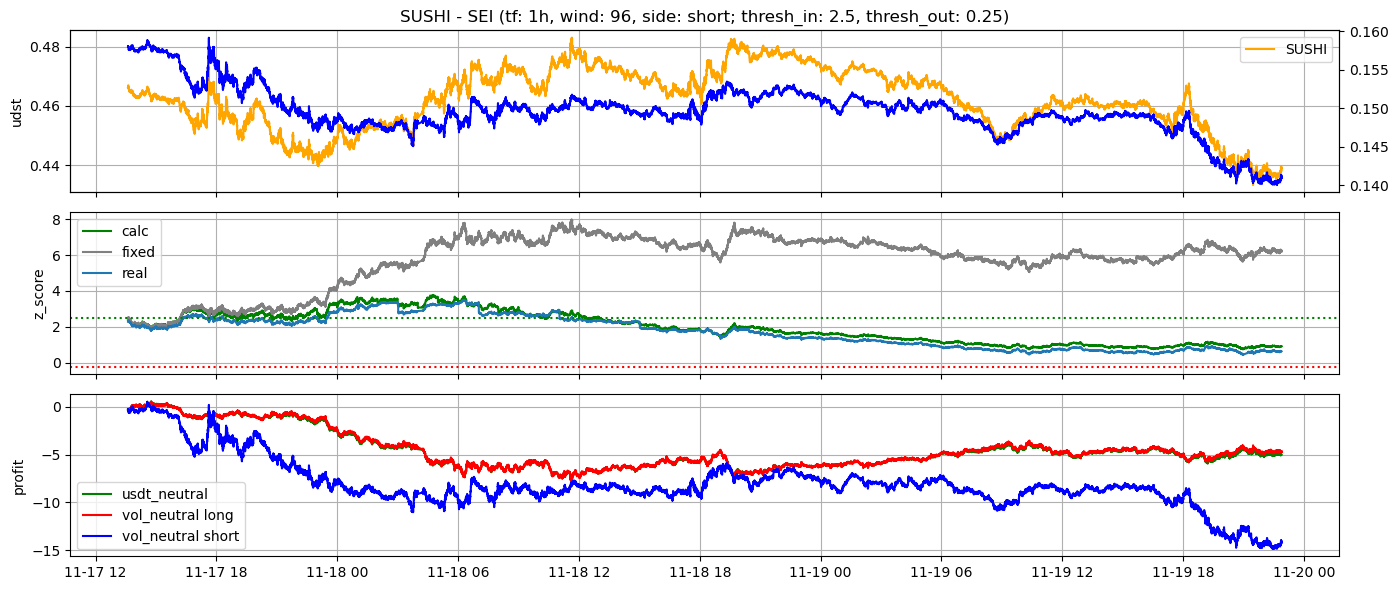

SUSHI - SEI. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-17 13:36:40; Цены. SUSHI: 0.46628027; SEI: 0.158; z_score: 2.28
Волатильность. (long): SUSHI: 0.0565, SEI: 0.0589; (short): SUSHI: 0.0040, SEI: 0.0012
std_ratio (long): 0.9596; std_ratio (short): 3.4038
Коэффициент хеджирования beta. beta_1: 1.452, beta_2: 0.534
Корреляция в предыдущие сутки: -0.98
Чувствительность в предыдущие сутки: Общая: -1.75; Pos: -1.79; Neg: -1.72
[CLOSE] Время: 2025-11-19 22:53:20; Цены. SUSHI: 0.4383; SEI: 0.1409; z_score: 0.63
Corr. Usdt: 0.19; Vol-neut short: 0.30; Vol-neut long: 0.18
Чувствительность. Общая: -3.27; Pos: -3.21; Neg: -3.32

[PROFIT]
usdt-neutral     : 213.9 SUSHI(short): 5.80$, 632.0 SEI(long): -10.99$; total profit: -5.19$
vol-neutral long : 218.3 SUSHI(short): 6.00$, 618.0 SEI(long): -10.67$; total profit: -4.67$
vol-neutral short: 97.1 SUSHI(short): 2.67$, 976.0 SEI(long): -16.85$; total profit: -14.18$
beta-neutral: 363.0 SUSHI(sho

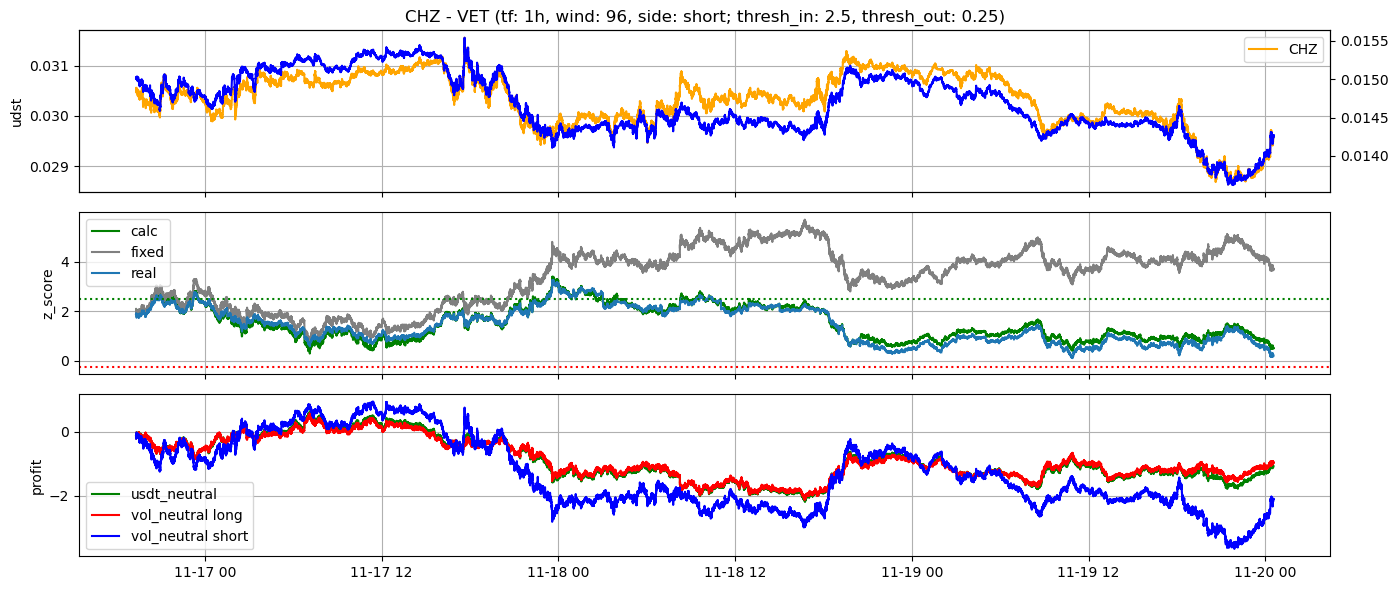

CHZ - VET. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-16 19:19:15; Цены. CHZ: 0.03051; VET: 0.01501; z_score: 1.88
Волатильность. (long): CHZ: 0.0406, VET: 0.0436; (short): CHZ: 0.0002, VET: 0.0001
std_ratio (long): 0.9312; std_ratio (short): 1.6646
Коэффициент хеджирования beta. beta_1: 0.795, beta_2: 1.122
Корреляция в предыдущие сутки: -0.90
Чувствительность в предыдущие сутки: Общая: -1.00; Pos: -1.55; Neg: -0.45
[CLOSE] Время: 2025-11-20 00:33:34; Цены. CHZ: 0.02963; VET: 0.01428; z_score: 0.22
Corr. Usdt: -0.34; Vol-neut short: -0.33; Vol-neut long: -0.33
Чувствительность. Общая: -0.90; Pos: -1.10; Neg: -0.71

[PROFIT]
usdt-neutral     : 1634.0 CHZ(short): 1.32$, 3327.0 VET(long): -2.57$; total profit: -1.24$
vol-neutral long : 1693.0 CHZ(short): 1.43$, 3205.0 VET(long): -2.39$; total profit: -0.96$
vol-neutral short: 1227.0 CHZ(short): 1.04$, 4152.0 VET(long): -3.10$; total profit: -2.06$
beta-neutral: 2110.0 CHZ(short): 1.79$

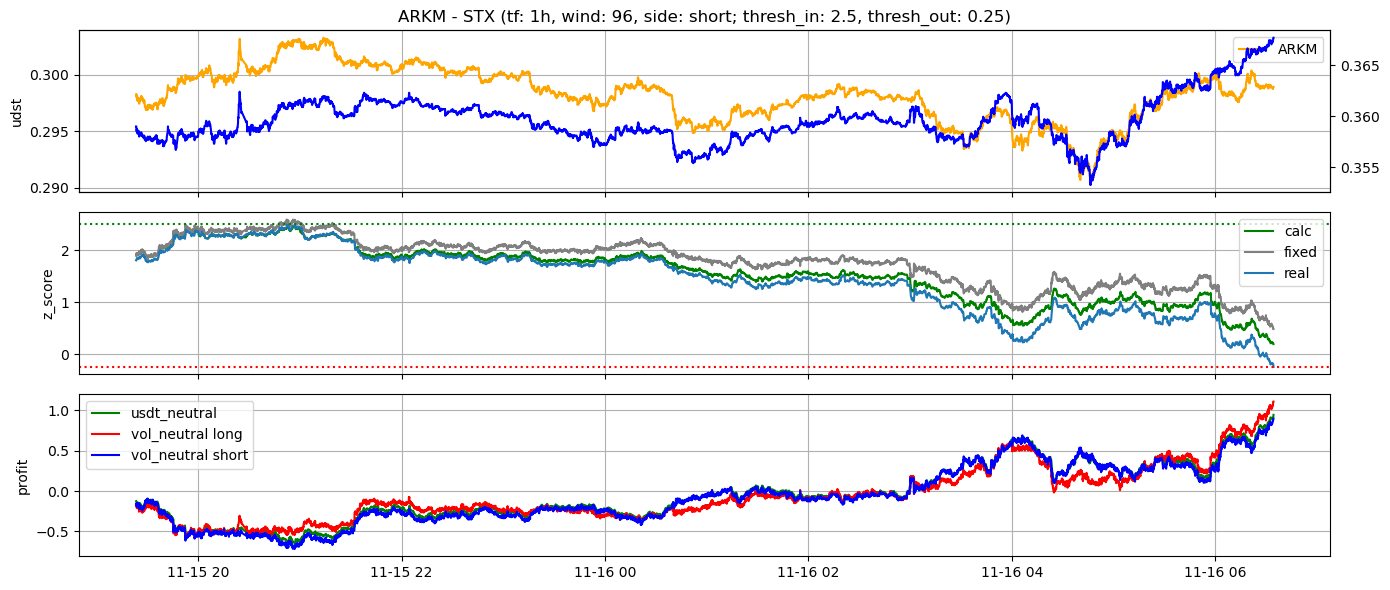

ARKM - STX. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-15 19:23:15; Цены. ARKM: 0.29819341; STX: 0.3591; z_score: 1.81
Волатильность. (long): ARKM: 0.0616, STX: 0.0474; (short): ARKM: 0.0031, STX: 0.0033
std_ratio (long): 1.2982; std_ratio (short): 0.9422
Коэффициент хеджирования beta. beta_1: 1.146, beta_2: 0.702
Корреляция в предыдущие сутки: -0.96
Чувствительность в предыдущие сутки: Общая: -0.78; Pos: -0.78; Neg: -0.78
[CLOSE] Время: 2025-11-16 06:34:27; Цены. ARKM: 0.2991; STX: 0.3678; z_score: -0.24
Corr. Usdt: -0.99; Vol-neut short: -0.99; Vol-neut long: -0.96
Чувствительность. Общая: -0.92; Pos: -0.96; Neg: -0.87

[PROFIT]
usdt-neutral     : 167.0 ARKM(short): -0.25$, 138.5 STX(long): 1.10$; total profit: 0.85$
vol-neutral long : 145.0 ARKM(short): -0.18$, 156.9 STX(long): 1.30$; total profit: 1.12$
vol-neutral short: 172.0 ARKM(short): -0.21$, 134.7 STX(long): 1.12$; total profit: 0.91$
beta-neutral: 181.0 ARKM(short): -0.22

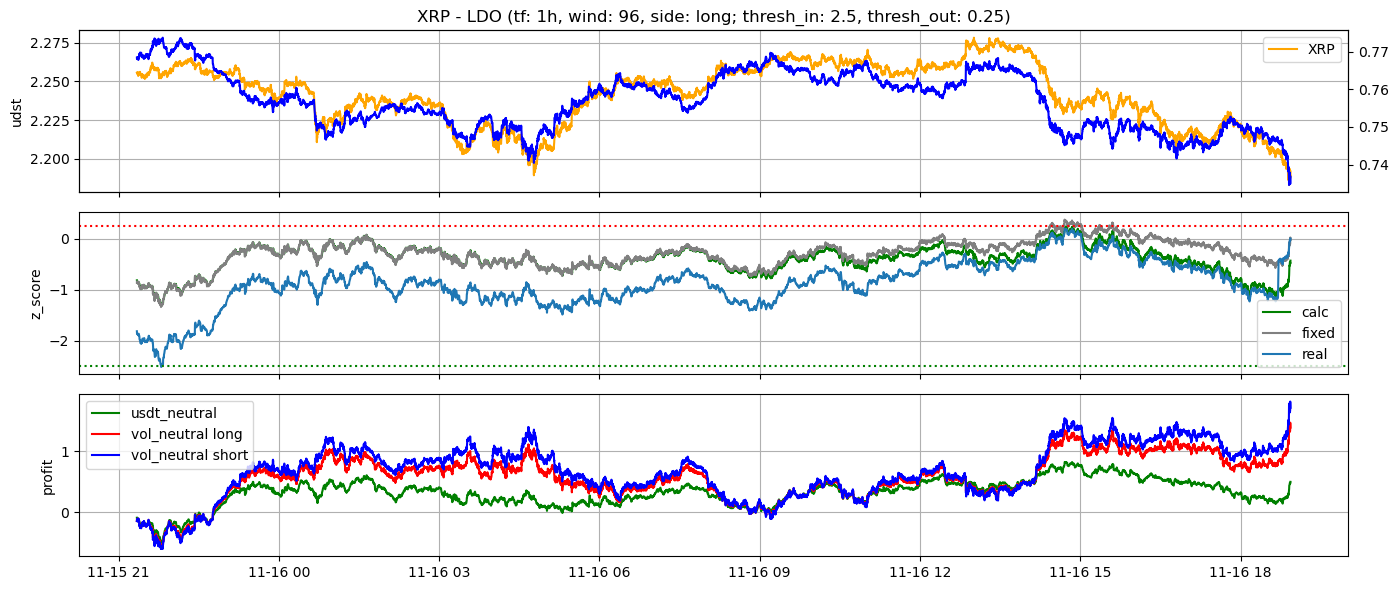

XRP - LDO. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-15 21:20:25; Цены. XRP: 2.2555; LDO: 0.7682; z_score: -1.81
Волатильность. (long): XRP: 0.0605, LDO: 0.0362; (short): XRP: 0.0162, LDO: 0.0079
std_ratio (long): 1.6729; std_ratio (short): 2.0527
Коэффициент хеджирования beta. beta_1: 0.831, beta_2: 0.885
Корреляция в предыдущие сутки: 0.92
Чувствительность в предыдущие сутки: Общая: 0.98; Pos: 0.99; Neg: 0.97
[CLOSE] Время: 2025-11-16 18:56:11; Цены. XRP: 2.1926; LDO: 0.7371; z_score: -0.00
Corr. Usdt: 0.85; Vol-neut short: 0.52; Vol-neut long: 0.60
Чувствительность. Общая: 0.78; Pos: 0.77; Neg: 0.79

[PROFIT]
usdt-neutral     : 22.1 XRP(long): -1.49$, 65.0 LDO(short): 1.93$; total profit: 0.44$
vol-neutral long : 16.5 XRP(long): -1.08$, 81.2 LDO(short): 2.46$; total profit: 1.38$
vol-neutral short: 14.4 XRP(long): -0.94$, 87.3 LDO(short): 2.64$; total profit: 1.70$
beta-neutral: 34.0 XRP(long): -2.22$, 30.1 LDO(short): 0.91$; tota

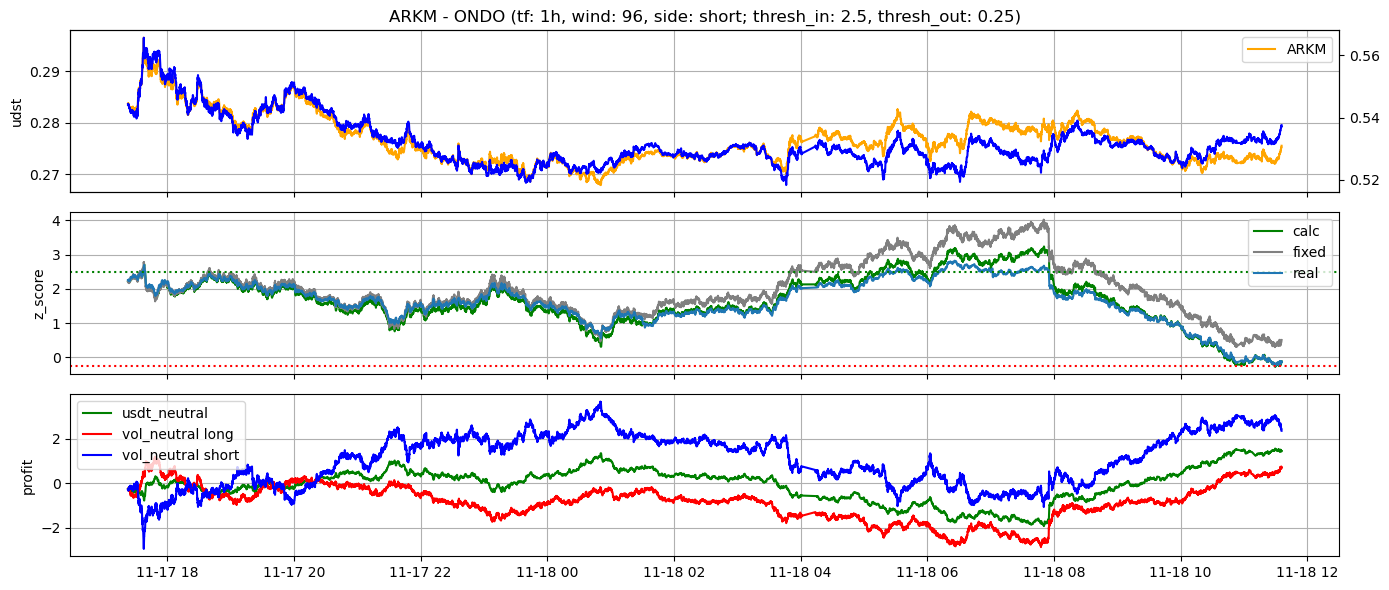

ARKM - ONDO. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-17 17:22:44; Цены. ARKM: 0.2836; ONDO: 0.5442; z_score: 2.25
Волатильность. (long): ARKM: 0.0616, ONDO: 0.0441; (short): ARKM: 0.0028, ONDO: 0.0046
std_ratio (long): 1.3946; std_ratio (short): 0.6082
Коэффициент хеджирования beta. beta_1: 1.118, beta_2: 0.797
Корреляция в предыдущие сутки: -0.99
Чувствительность в предыдущие сутки: Общая: -1.28; Pos: -1.18; Neg: -1.37
[CLOSE] Время: 2025-11-18 11:35:42; Цены. ARKM: 0.2753; ONDO: 0.537; z_score: -0.13
Corr. Usdt: -0.96; Vol-neut short: -0.84; Vol-neut long: -0.70
Чувствительность. Общая: -1.19; Pos: -1.18; Neg: -1.19

[PROFIT]
usdt-neutral     : 350.0 ARKM(short): 2.73$, 183.0 ONDO(long): -1.53$; total profit: 1.20$
vol-neutral long : 292.0 ARKM(short): 2.33$, 212.0 ONDO(long): -1.65$; total profit: 0.68$
vol-neutral short: 435.0 ARKM(short): 3.48$, 137.0 ONDO(long): -1.07$; total profit: 2.41$
beta-neutral: 277.0 ARKM(short): 2.

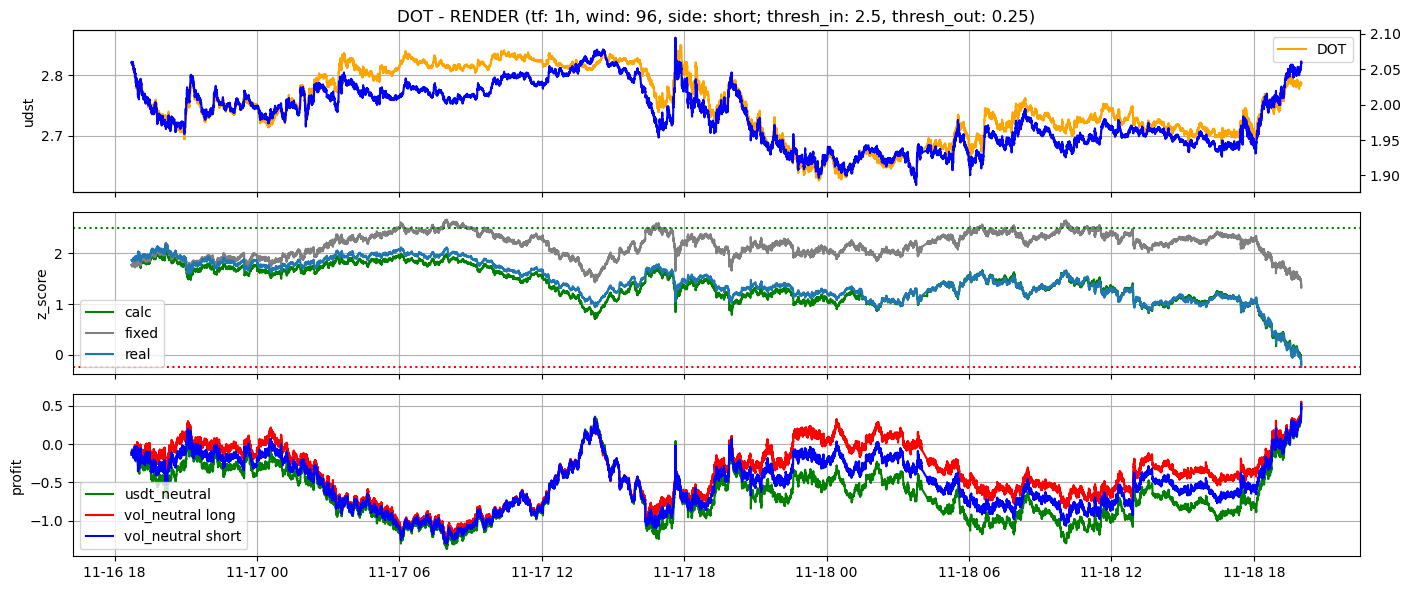

DOT - RENDER. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-16 18:42:37; Цены. DOT: 2.8202; RENDER: 2.059; z_score: 1.87
Волатильность. (long): DOT: 0.0449, RENDER: 0.0540; (short): DOT: 0.0217, RENDER: 0.0239
std_ratio (long): 0.8312; std_ratio (short): 0.9081
Коэффициент хеджирования beta. beta_1: 1.359, beta_2: 0.690
Корреляция в предыдущие сутки: -0.97
Чувствительность в предыдущие сутки: Общая: -1.49; Pos: -1.54; Neg: -1.44
[CLOSE] Время: 2025-11-18 20:00:06; Цены. DOT: 2.7855; RENDER: 2.059; z_score: -0.24
Corr. Usdt: -0.44; Vol-neut short: -0.51; Vol-neut long: -0.54
Чувствительность. Общая: -1.43; Pos: -1.41; Neg: -1.45

[PROFIT]
usdt-neutral     : 17.6 DOT(short): 0.53$, 24.2 RENDER(long): -0.13$; total profit: 0.40$
vol-neutral long : 19.1 DOT(short): 0.60$, 21.7 RENDER(long): -0.05$; total profit: 0.55$
vol-neutral short: 18.3 DOT(short): 0.58$, 22.8 RENDER(long): -0.05$; total profit: 0.53$
beta-neutral: 23.3 DOT(short): 0.7

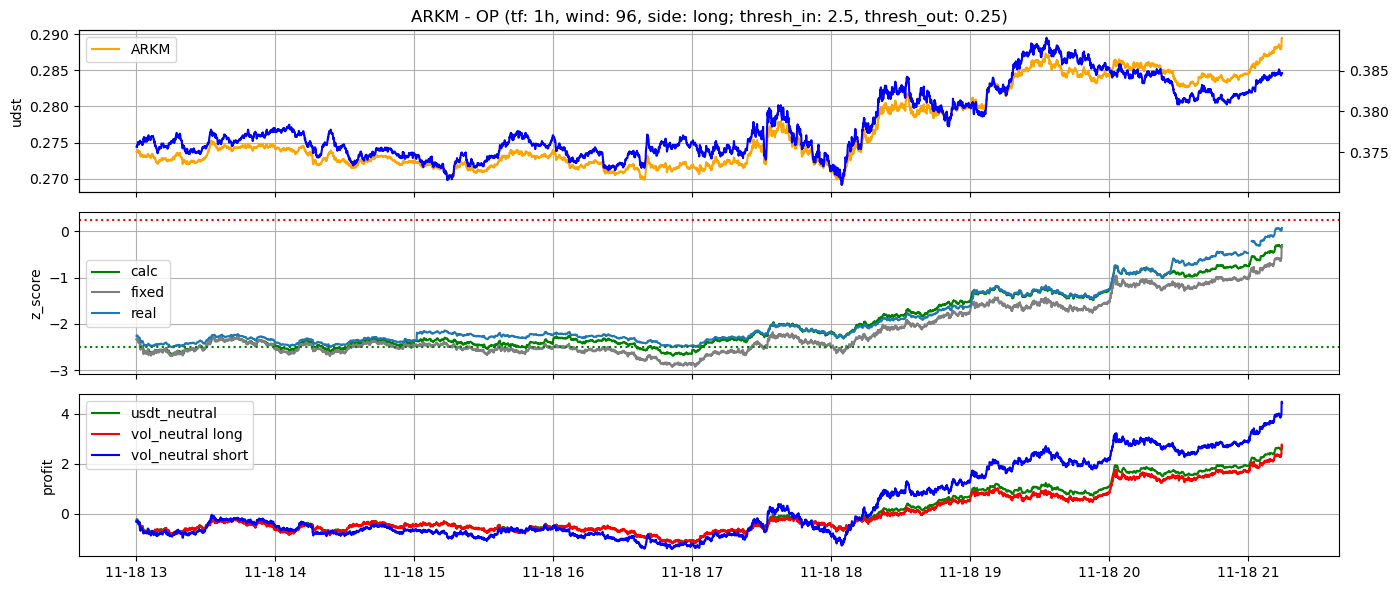

ARKM - OP. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-18 13:00:15; Цены. ARKM: 0.2739; OP: 0.3758; z_score: -2.26
Волатильность. (long): ARKM: 0.0616, OP: 0.0581; (short): ARKM: 0.0023, OP: 0.0033
std_ratio (long): 1.0595; std_ratio (short): 0.6866
Коэффициент хеджирования beta. beta_1: 1.242, beta_2: 0.750
Корреляция в предыдущие сутки: 0.99
Чувствительность в предыдущие сутки: Общая: 1.93; Pos: 1.84; Neg: 2.03
[CLOSE] Время: 2025-11-18 21:14:41; Цены. ARKM: 0.2892; OP: 0.3846; z_score: 0.07
Corr. Usdt: 0.99; Vol-neut short: 0.98; Vol-neut long: 0.99
Чувствительность. Общая: 2.00; Pos: 2.04; Neg: 1.96

[PROFIT]
usdt-neutral     : 364.0 ARKM(long): 5.36$, 265.0 OP(short): -2.53$; total profit: 2.84$
vol-neutral long : 351.0 ARKM(long): 5.26$, 271.8 OP(short): -2.51$; total profit: 2.76$
vol-neutral short: 429.0 ARKM(long): 6.43$, 215.1 OP(short): -1.98$; total profit: 4.45$
beta-neutral: 357.0 ARKM(long): 5.35$, 267.6 OP(short): -2.47

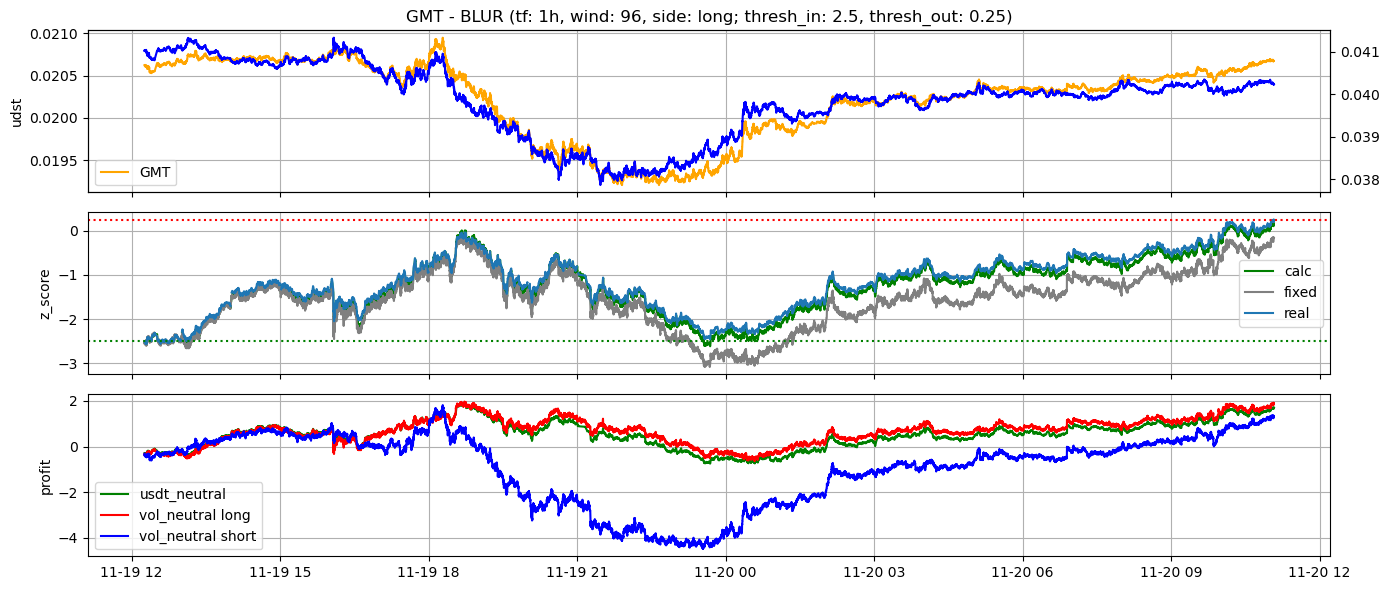

GMT - BLUR. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-19 12:15:37; Цены. GMT: 0.02063; BLUR: 0.04101; z_score: -2.50
Волатильность. (long): GMT: 0.0504, BLUR: 0.0474; (short): GMT: 0.0001, BLUR: 0.0003
std_ratio (long): 1.0632; std_ratio (short): 0.5349
Коэффициент хеджирования beta. beta_1: 0.575, beta_2: 1.627
Корреляция в предыдущие сутки: 0.99
Чувствительность в предыдущие сутки: Общая: 1.07; Pos: 0.92; Neg: 1.22
[CLOSE] Время: 2025-11-20 11:04:46; Цены. GMT: 0.02067; BLUR: 0.04023; z_score: 0.25
Corr. Usdt: 0.96; Vol-neut short: 0.54; Vol-neut long: 0.96
Чувствительность. Общая: 0.61; Pos: 0.51; Neg: 0.71

[PROFIT]
usdt-neutral     : 4837.0 GMT(long): -0.02$, 2435.0 BLUR(short): 1.70$; total profit: 1.68$
vol-neutral long : 4688.0 GMT(long): 0.08$, 2507.0 BLUR(short): 1.84$; total profit: 1.92$
vol-neutral short: 6302.0 GMT(long): 0.11$, 1695.0 BLUR(short): 1.25$; total profit: 1.36$
beta-neutral: 2288.0 GMT(long): 0.04$, 3722.0

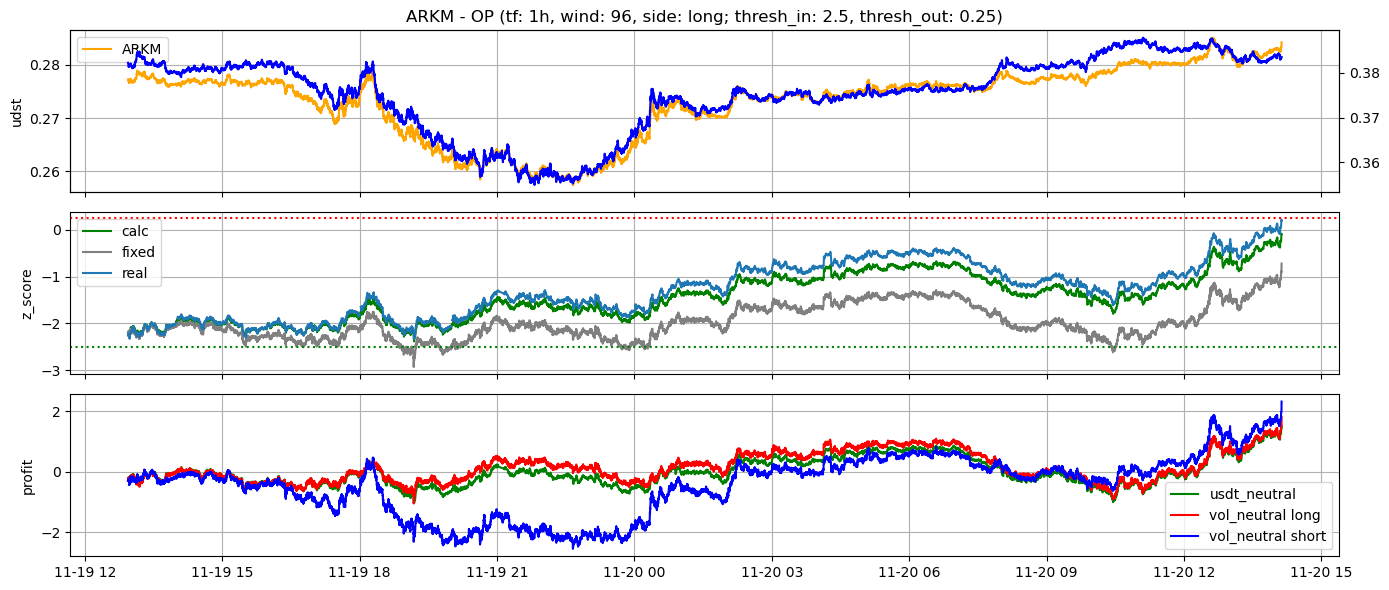

ARKM - OP. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-19 12:56:25; Цены. ARKM: 0.2773; OP: 0.3822; z_score: -2.26
Волатильность. (long): ARKM: 0.0616, OP: 0.0581; (short): ARKM: 0.0023, OP: 0.0031
std_ratio (long): 1.0595; std_ratio (short): 0.7421
Коэффициент хеджирования beta. beta_1: 1.242, beta_2: 0.750
Корреляция в предыдущие сутки: 0.99
Чувствительность в предыдущие сутки: Общая: 1.83; Pos: 1.86; Neg: 1.79
[CLOSE] Время: 2025-11-20 14:08:07; Цены. ARKM: 0.2841; OP: 0.3835; z_score: 0.20
Corr. Usdt: 0.92; Vol-neut short: 0.72; Vol-neut long: 0.87
Чувствительность. Общая: 1.73; Pos: 1.70; Neg: 1.77

[PROFIT]
usdt-neutral     : 360.0 ARKM(long): 2.22$, 260.9 OP(short): -0.52$; total profit: 1.70$
vol-neutral long : 349.0 ARKM(long): 2.27$, 268.6 OP(short): -0.46$; total profit: 1.80$
vol-neutral short: 413.0 ARKM(long): 2.68$, 222.4 OP(short): -0.38$; total profit: 2.30$
beta-neutral: 354.0 ARKM(long): 2.30$, 265.3 OP(short): -0.46

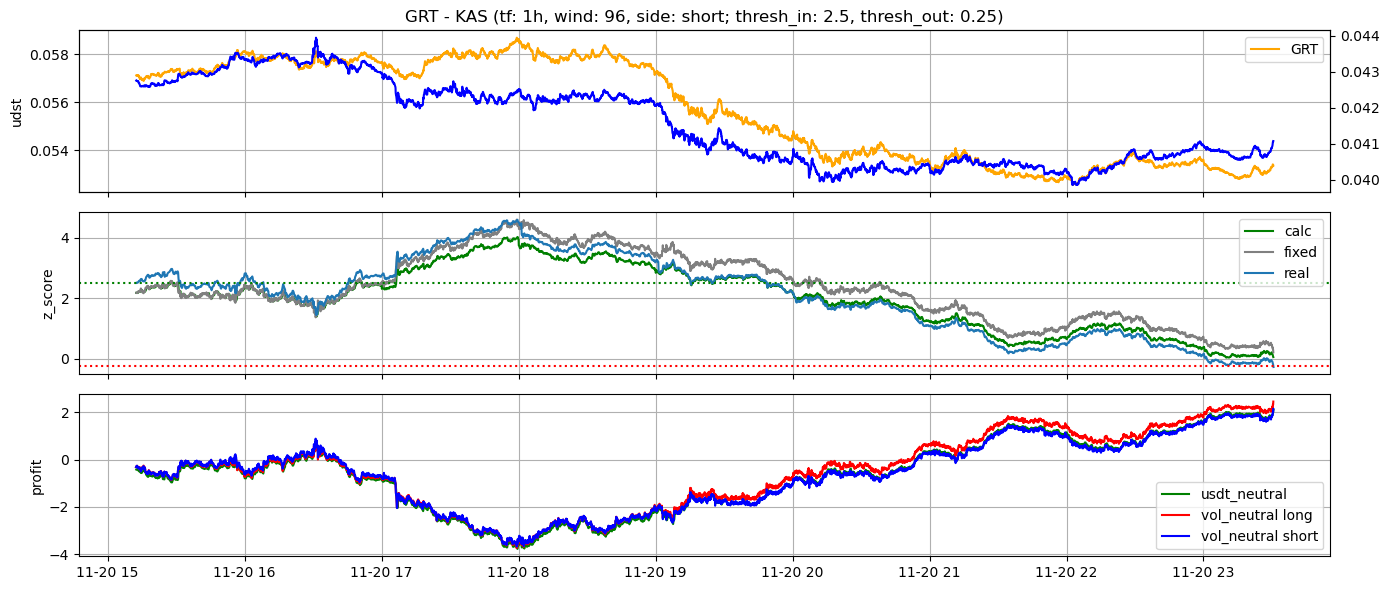

GRT - KAS. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-20 15:12:25; Цены. GRT: 0.0571; KAS: 0.04275; z_score: 2.51
Волатильность. (long): GRT: 0.0492, KAS: 0.0504; (short): GRT: 0.0004, KAS: 0.0004
std_ratio (long): 0.9753; std_ratio (short): 1.0359
Коэффициент хеджирования beta. beta_1: 1.058, beta_2: 0.905
Корреляция в предыдущие сутки: -0.98
Чувствительность в предыдущие сутки: Общая: -1.76; Pos: -1.72; Neg: -1.81
[CLOSE] Время: 2025-11-20 23:30:42; Цены. GRT: 0.05339; KAS: 0.04113; z_score: -0.28
Corr. Usdt: -0.98; Vol-neut short: -0.98; Vol-neut long: -0.99
Чувствительность. Общая: -1.65; Pos: -1.66; Neg: -1.64

[PROFIT]
usdt-neutral     : 1742.5 GRT(short): 6.28$, 2330.0 KAS(long): -3.95$; total profit: 2.33$
vol-neutral long : 1760.4 GRT(short): 6.42$, 2290.0 KAS(long): -3.82$; total profit: 2.61$
vol-neutral short: 1708.1 GRT(short): 6.23$, 2360.0 KAS(long): -3.93$; total profit: 2.30$
beta-neutral: 2076.6 GRT(short): 7.58$, 1

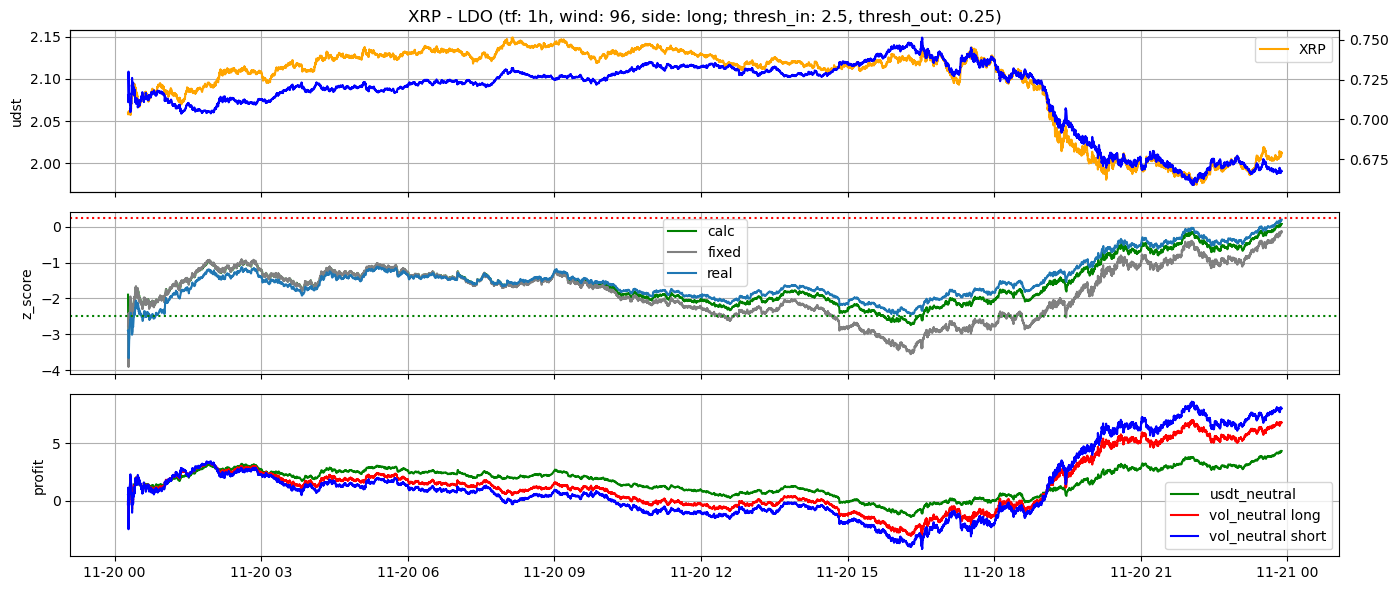

XRP - LDO. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-20 00:16:15; Цены. XRP: 2.0593; LDO: 0.7181; z_score: -2.89
Волатильность. (long): XRP: 0.0605, LDO: 0.0362; (short): XRP: 0.0144, LDO: 0.0064
std_ratio (long): 1.6729; std_ratio (short): 2.2473
Коэффициент хеджирования beta. beta_1: 0.831, beta_2: 0.885
Корреляция в предыдущие сутки: 1.00
Чувствительность в предыдущие сутки: Общая: 1.69; Pos: 1.74; Neg: 1.64
[CLOSE] Время: 2025-11-20 23:52:56; Цены. XRP: 2.0124; LDO: 0.6677; z_score: 0.20
Corr. Usdt: 0.92; Vol-neut short: 0.95; Vol-neut long: 0.97
Чувствительность. Общая: 2.04; Pos: 2.04; Neg: 2.04

[PROFIT]
usdt-neutral     : 48.4 XRP(long): -2.48$, 139.0 LDO(short): 6.82$; total profit: 4.34$
vol-neutral long : 36.0 XRP(long): -1.77$, 173.0 LDO(short): 8.59$; total profit: 6.82$
vol-neutral short: 29.6 XRP(long): -1.45$, 191.3 LDO(short): 9.50$; total profit: 8.04$
beta-neutral: 73.7 XRP(long): -3.62$, 65.2 LDO(short): 3.24$; to

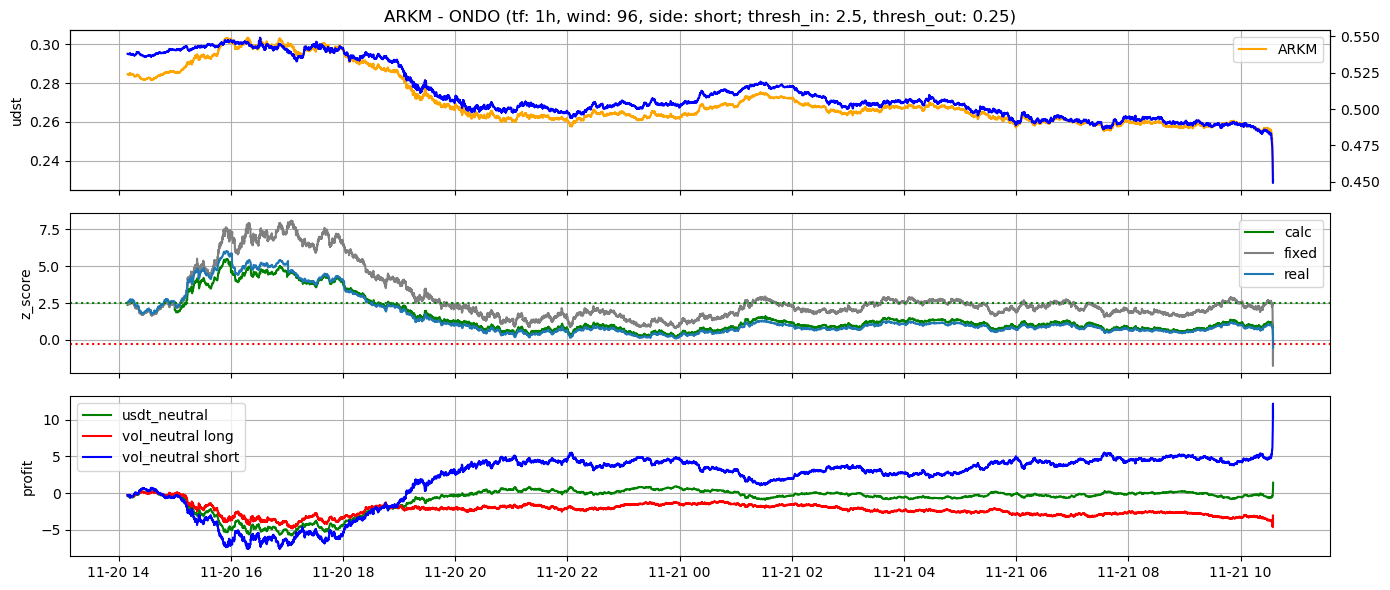

ARKM - ONDO. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-20 14:09:35; Цены. ARKM: 0.2844; ONDO: 0.5381; z_score: 2.54
Волатильность. (long): ARKM: 0.0616, ONDO: 0.0441; (short): ARKM: 0.0024, ONDO: 0.0041
std_ratio (long): 1.3946; std_ratio (short): 0.5875
Коэффициент хеджирования beta. beta_1: 1.118, beta_2: 0.797
Корреляция в предыдущие сутки: -1.00
Чувствительность в предыдущие сутки: Общая: -1.02; Pos: -1.03; Neg: -1.01
[CLOSE] Время: 2025-11-21 10:34:41; Цены. ARKM: 0.2354; ONDO: 0.4542; z_score: -0.51
Corr. Usdt: -0.97; Vol-neut short: -0.98; Vol-neut long: -0.38
Чувствительность. Общая: -1.42; Pos: -1.38; Neg: -1.46

[PROFIT]
usdt-neutral     : 349.0 ARKM(short): 16.91$, 185.0 ONDO(long): -15.69$; total profit: 1.22$
vol-neutral long : 291.0 ARKM(short): 14.18$, 214.0 ONDO(long): -18.07$; total profit: -3.90$
vol-neutral short: 439.0 ARKM(short): 21.39$, 136.0 ONDO(long): -11.48$; total profit: 9.90$
beta-neutral: 278.0 ARKM(sh

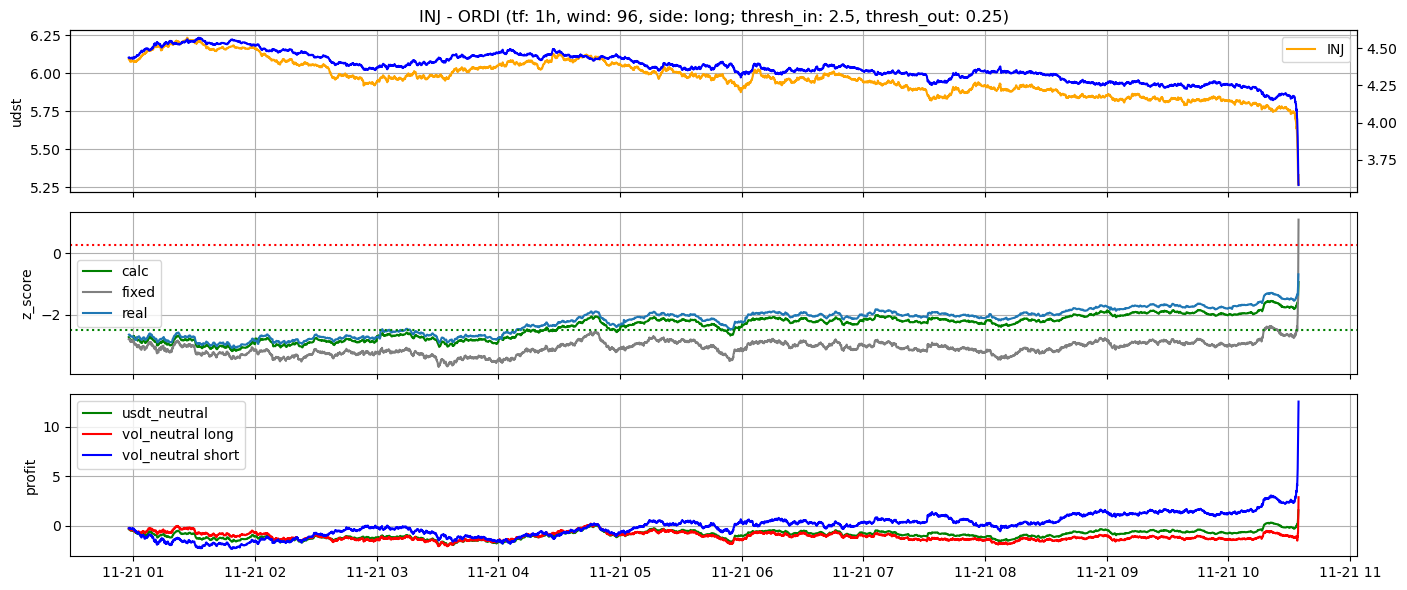

INJ - ORDI. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-21 00:57:36; Цены. INJ: 6.096; ORDI: 4.43769895; z_score: -2.65
Волатильность. (long): INJ: 0.0570, ORDI: 0.0698; (short): INJ: 0.0739, ORDI: 0.0454
std_ratio (long): 0.8163; std_ratio (short): 1.6281
Коэффициент хеджирования beta. beta_1: 1.038, beta_2: 0.931
Корреляция в предыдущие сутки: 1.00
Чувствительность в предыдущие сутки: Общая: 1.65; Pos: 1.64; Neg: 1.65
[CLOSE] Время: 2025-11-21 10:34:44; Цены. INJ: 5.378; ORDI: 3.447; z_score: -0.69
Corr. Usdt: 0.80; Vol-neut short: 0.93; Vol-neut long: 0.11
Чувствительность. Общая: 2.41; Pos: 2.47; Neg: 2.35

[PROFIT]
usdt-neutral     : 14.6 INJ(long): -10.61$, 20.03 ORDI(short): 19.69$; total profit: 9.09$
vol-neutral long : 16.0 INJ(long): -11.59$, 17.98 ORDI(short): 17.73$; total profit: 6.15$
vol-neutral short: 11.0 INJ(long): -7.97$, 24.79 ORDI(short): 24.45$; total profit: 16.48$
beta-neutral: 17.3 INJ(long): -12.53$, 16.1 ORDI

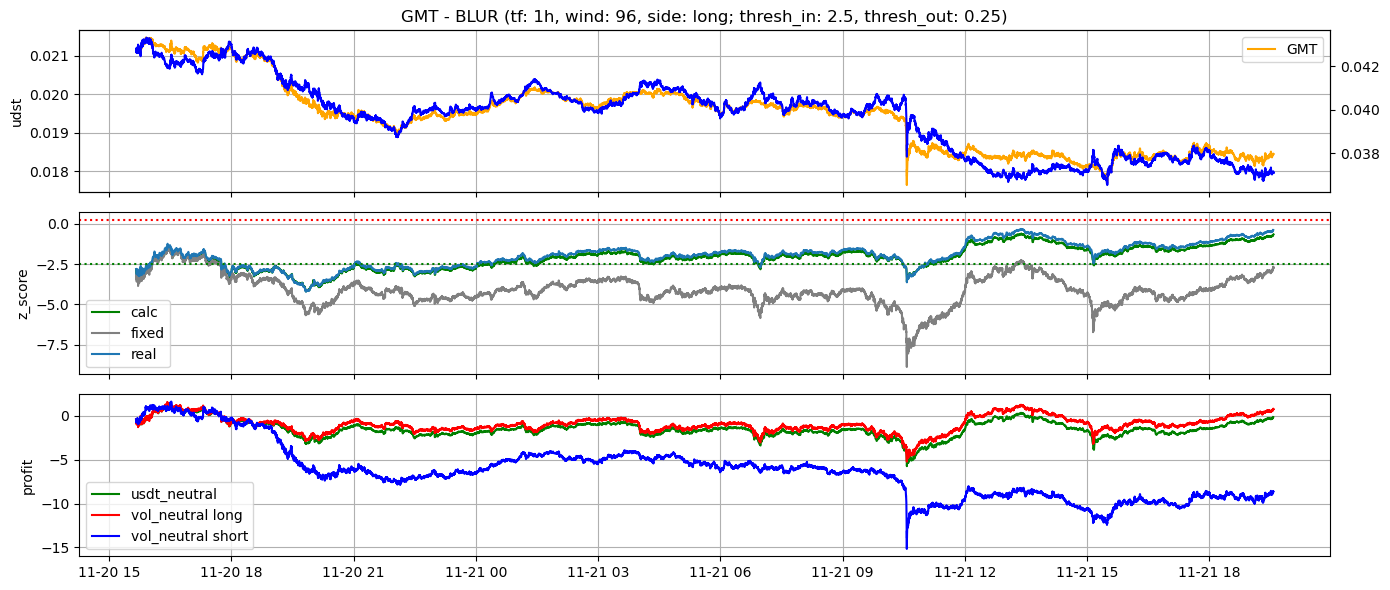

GMT - BLUR. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-20 15:39:25; Цены. GMT: 0.02110945; BLUR: 0.04261; z_score: -2.81
Волатильность. (long): GMT: 0.0504, BLUR: 0.0474; (short): GMT: 0.0002, BLUR: 0.0003
std_ratio (long): 1.0632; std_ratio (short): 0.4951
Коэффициент хеджирования beta. beta_1: 0.575, beta_2: 1.627
Корреляция в предыдущие сутки: 0.98
Чувствительность в предыдущие сутки: Общая: 0.75; Pos: 0.60; Neg: 0.91
[CLOSE] Время: 2025-11-21 19:34:31; Цены. GMT: 0.01844; BLUR: 0.03711; z_score: -0.39
Corr. Usdt: 0.45; Vol-neut short: -0.37; Vol-neut long: 0.61
Чувствительность. Общая: 1.99; Pos: 1.83; Neg: 2.15

[PROFIT]
usdt-neutral     : 4728.0 GMT(long): -12.82$, 2344.0 BLUR(short): 12.72$; total profit: -0.10$
vol-neutral long : 4582.0 GMT(long): -12.33$, 2413.0 BLUR(short): 13.17$; total profit: 0.83$
vol-neutral short: 6323.0 GMT(long): -17.02$, 1550.0 BLUR(short): 8.46$; total profit: -8.56$
beta-neutral: 2210.0 GMT(long):

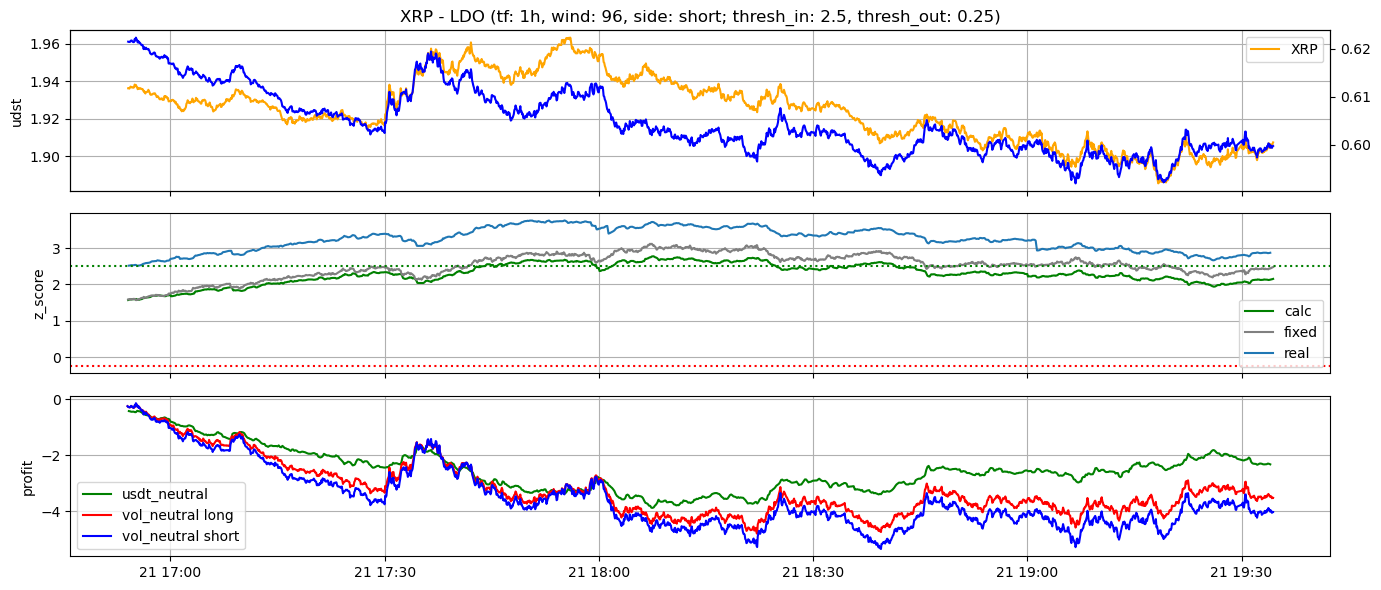

XRP - LDO. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-21 16:54:00; Цены. XRP: 1.9361; LDO: 0.6216; z_score: 2.52
Волатильность. (long): XRP: 0.0605, LDO: 0.0362; (short): XRP: 0.0166, LDO: 0.0079
std_ratio (long): 1.6729; std_ratio (short): 2.0926
Коэффициент хеджирования beta. beta_1: 0.831, beta_2: 0.885
Корреляция в предыдущие сутки: -1.00
Чувствительность в предыдущие сутки: Общая: -2.00; Pos: -1.95; Neg: -2.04
[CLOSE] Время: 2025-11-21 19:34:33; Цены. XRP: 1.9064; LDO: 0.5994; z_score: 2.87
Corr. Usdt: -0.98; Vol-neut short: -0.73; Vol-neut long: -0.81
Чувствительность. Общая: -2.53; Pos: -2.65; Neg: -2.41

[PROFIT]
usdt-neutral     : 51.5 XRP(short): 1.34$, 160.6 LDO(long): -3.77$; total profit: -2.43$
vol-neutral long : 38.5 XRP(short): 1.06$, 200.9 LDO(long): -4.59$; total profit: -3.53$
vol-neutral short: 33.3 XRP(short): 0.92$, 217.2 LDO(long): -4.97$; total profit: -4.05$
beta-neutral: 80.3 XRP(short): 2.22$, 71.0 LDO(long

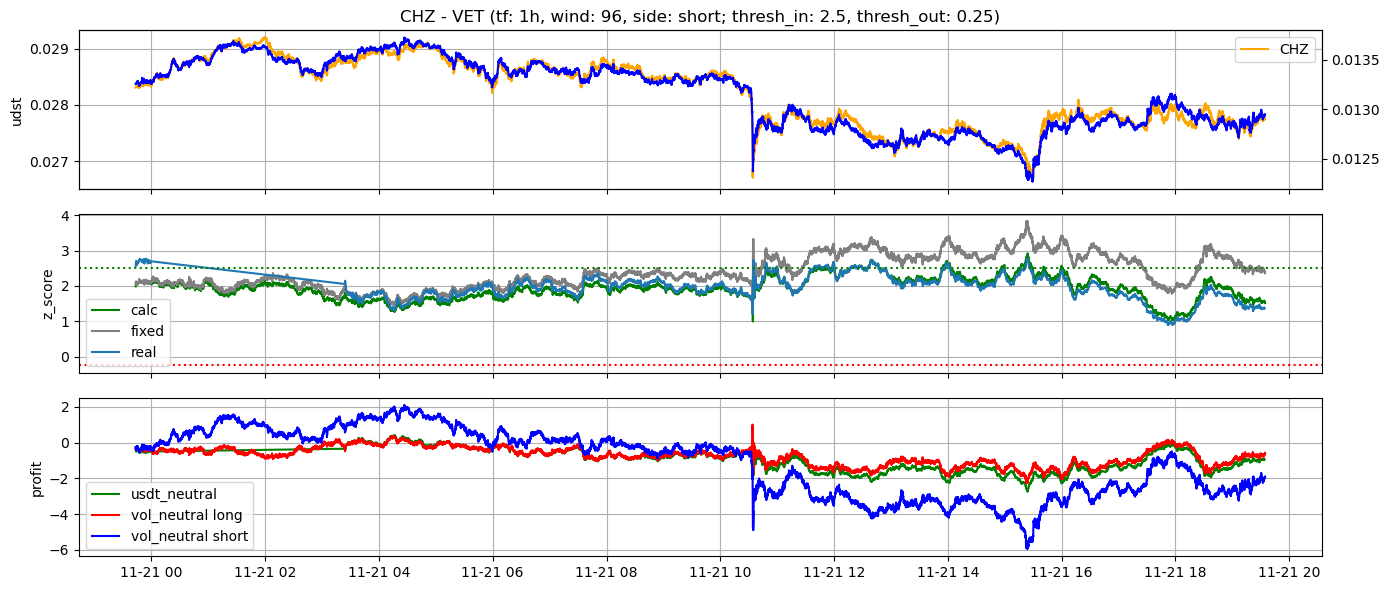

CHZ - VET. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-20 23:43:25; Цены. CHZ: 0.0283; VET: 0.01326; z_score: 2.56
Волатильность. (long): CHZ: 0.0406, VET: 0.0436; (short): CHZ: 0.0002, VET: 0.0001
std_ratio (long): 0.9312; std_ratio (short): 1.7405
Коэффициент хеджирования beta. beta_1: 0.795, beta_2: 1.122
Корреляция в предыдущие сутки: -1.00
Чувствительность в предыдущие сутки: Общая: -1.80; Pos: -1.80; Neg: -1.81
[CLOSE] Время: 2025-11-21 19:34:36; Цены. CHZ: 0.02775; VET: 0.01293; z_score: 1.36
Corr. Usdt: -0.84; Vol-neut short: -0.67; Vol-neut long: -0.88
Чувствительность. Общая: -1.76; Pos: -1.86; Neg: -1.67

[PROFIT]
usdt-neutral     : 3525.0 CHZ(short): 1.67$, 7527.0 VET(long): -2.69$; total profit: -1.02$
vol-neutral long : 3651.0 CHZ(short): 1.90$, 7257.0 VET(long): -2.50$; total profit: -0.60$
vol-neutral short: 2573.0 CHZ(short): 1.34$, 9558.0 VET(long): -3.29$; total profit: -1.96$
beta-neutral: 4629.0 CHZ(short): 2.40$,

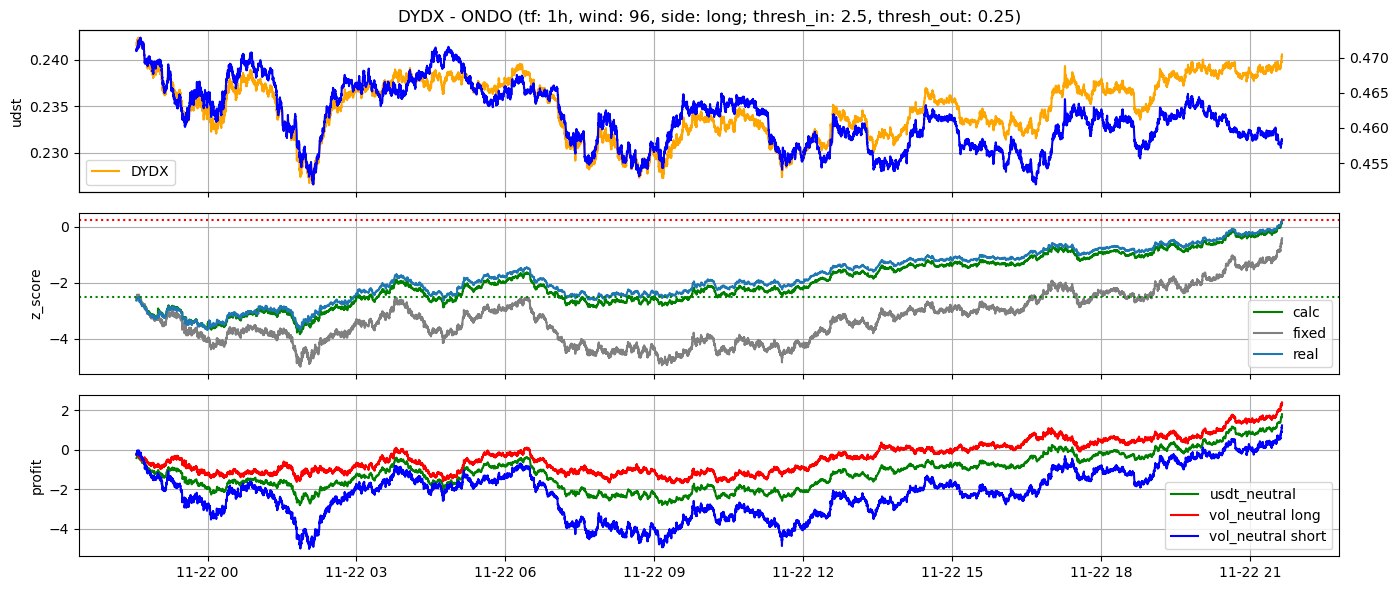

DYDX - ONDO. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-21 22:34:01; Цены. DYDX: 0.2416; ONDO: 0.471; z_score: -2.63
Волатильность. (long): DYDX: 0.0576, ONDO: 0.0441; (short): DYDX: 0.0031, ONDO: 0.0051
std_ratio (long): 1.3038; std_ratio (short): 0.6070
Коэффициент хеджирования beta. beta_1: 0.843, beta_2: 1.042
Корреляция в предыдущие сутки: 0.98
Чувствительность в предыдущие сутки: Общая: 1.18; Pos: 1.20; Neg: 1.15
[CLOSE] Время: 2025-11-22 21:38:52; Цены. DYDX: 0.2404; ONDO: 0.4582; z_score: 0.24
Corr. Usdt: 0.85; Vol-neut short: 0.67; Vol-neut long: 0.91
Чувствительность. Общая: 1.78; Pos: 2.07; Neg: 1.49

[PROFIT]
usdt-neutral     : 410.8 DYDX(long): -0.67$, 211.0 ONDO(short): 2.53$; total profit: 1.86$
vol-neutral long : 356.7 DYDX(long): -0.52$, 238.0 ONDO(short): 2.92$; total profit: 2.40$
vol-neutral short: 511.4 DYDX(long): -0.75$, 159.0 ONDO(short): 1.95$; total profit: 1.20$
beta-neutral: 271.5 DYDX(long): -0.40$, 282.0 

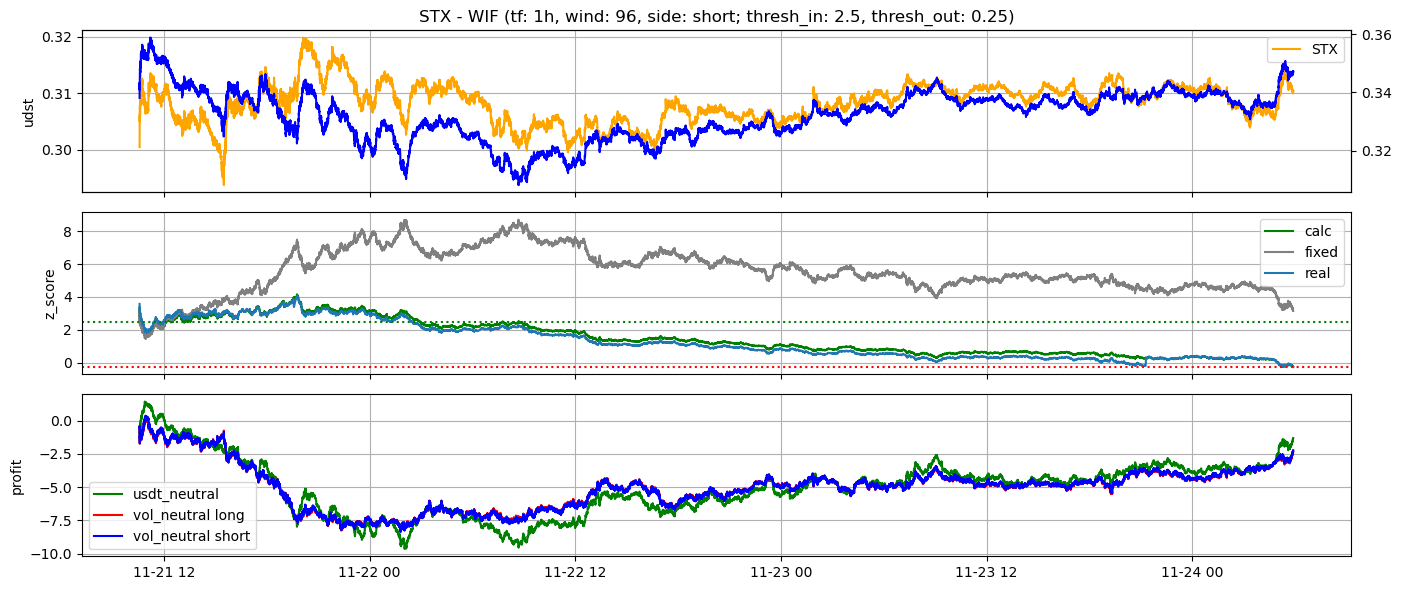

STX - WIF. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-21 10:34:42; Цены. STX: 0.30039976; WIF: 0.3389; z_score: 3.58
Волатильность. (long): STX: 0.0474, WIF: 0.0716; (short): STX: 0.0033, WIF: 0.0048
std_ratio (long): 0.6625; std_ratio (short): 0.6812
Коэффициент хеджирования beta. beta_1: 1.334, beta_2: 0.738
Корреляция в предыдущие сутки: -1.00
Чувствительность в предыдущие сутки: Общая: -1.38; Pos: -1.38; Neg: -1.38
[CLOSE] Время: 2025-11-24 05:52:56; Цены. STX: 0.3105; WIF: 0.3472; z_score: -0.25
Corr. Usdt: -0.35; Vol-neut short: -0.34; Vol-neut long: -0.33
Чувствительность. Общая: -4.97; Pos: -5.01; Neg: -4.93

[PROFIT]
usdt-neutral     : 333.0 STX(short): -3.53$, 296.0 WIF(long): 2.32$; total profit: -1.21$
vol-neutral long : 399.5 STX(short): -4.17$, 234.0 WIF(long): 1.85$; total profit: -2.32$
vol-neutral short: 395.1 STX(short): -4.12$, 238.0 WIF(long): 1.89$; total profit: -2.24$
beta-neutral: 363.0 STX(short): -3.79$, 267

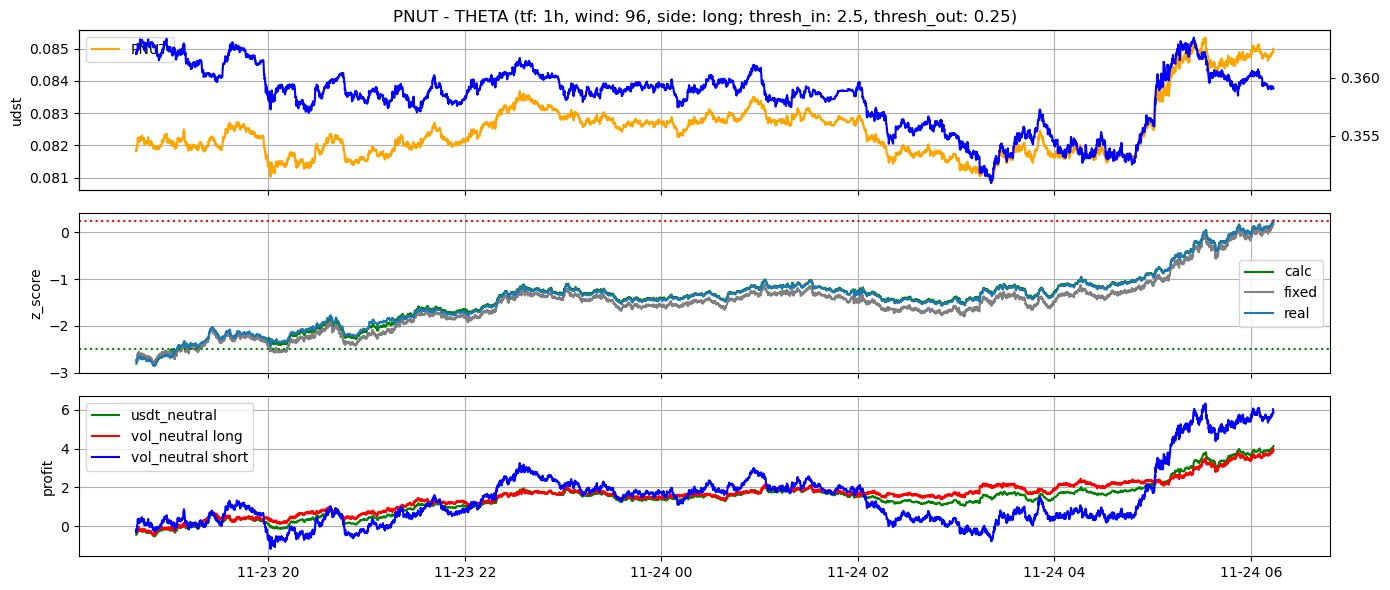

PNUT - THETA. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-23 18:39:13; Цены. PNUT: 0.08184; THETA: 0.36192385; z_score: -2.81
Волатильность. (long): PNUT: 0.0674, THETA: 0.0531; (short): PNUT: 0.0012, THETA: 0.0039
std_ratio (long): 1.2696; std_ratio (short): 0.2983
Коэффициент хеджирования beta. beta_1: 1.803, beta_2: 0.506
Корреляция в предыдущие сутки: 0.96
Чувствительность в предыдущие сутки: Общая: 1.22; Pos: 1.22; Neg: 1.22
[CLOSE] Время: 2025-11-24 06:13:58; Цены. PNUT: 0.08493; THETA: 0.359; z_score: 0.25
Corr. Usdt: 0.99; Vol-neut short: 0.82; Vol-neut long: 0.99
Чувствительность. Общая: 1.85; Pos: 1.85; Neg: 1.86

[PROFIT]
usdt-neutral     : 1220.0 PNUT(long): 3.55$, 275.5 THETA(short): 0.61$; total profit: 4.16$
vol-neutral long : 1074.0 PNUT(long): 3.22$, 308.4 THETA(short): 0.78$; total profit: 4.00$
vol-neutral short: 1878.0 PNUT(long): 5.63$, 126.6 THETA(short): 0.32$; total profit: 5.95$
beta-neutral: 754.0 PNUT(long): 

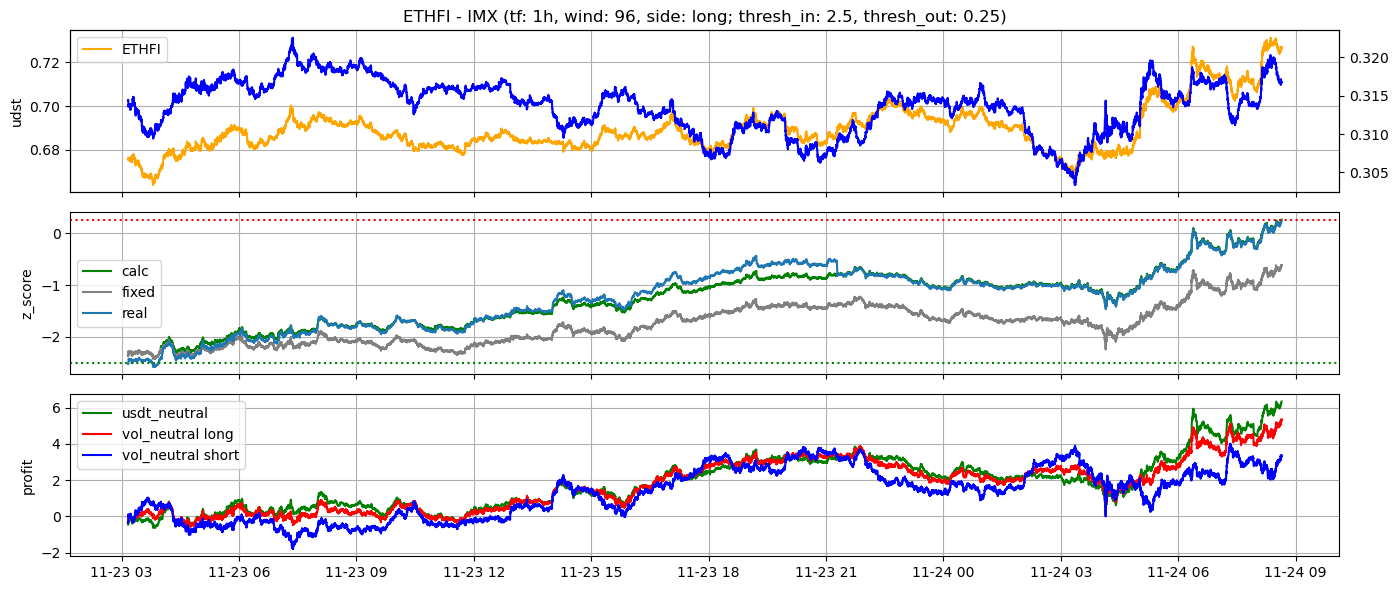

ETHFI - IMX. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-23 03:09:50; Цены. ETHFI: 0.6756; IMX: 0.3143; z_score: -2.52
Волатильность. (long): ETHFI: 0.0784, IMX: 0.0591; (short): ETHFI: 0.0089, IMX: 0.0040
std_ratio (long): 1.3271; std_ratio (short): 2.2195
Коэффициент хеджирования beta. beta_1: 0.628, beta_2: 1.401
Корреляция в предыдущие сутки: 0.74
Чувствительность в предыдущие сутки: Общая: 3.09; Pos: 3.04; Neg: 3.13
[CLOSE] Время: 2025-11-24 08:38:28; Цены. ETHFI: 0.7268561; IMX: 0.3167; z_score: 0.24
Corr. Usdt: 0.98; Vol-neut short: 0.83; Vol-neut long: 0.96
Чувствительность. Общая: 4.38; Pos: 4.43; Neg: 4.32

[PROFIT]
usdt-neutral     : 147.6 ETHFI(long): 7.39$, 317.8 IMX(short): -0.93$; total profit: 6.46$
vol-neutral long : 126.9 ETHFI(long): 6.41$, 362.0 IMX(short): -0.99$; total profit: 5.41$
vol-neutral short: 91.7 ETHFI(long): 4.63$, 437.7 IMX(short): -1.20$; total profit: 3.43$
beta-neutral: 179.0 ETHFI(long): 9.04$, 250

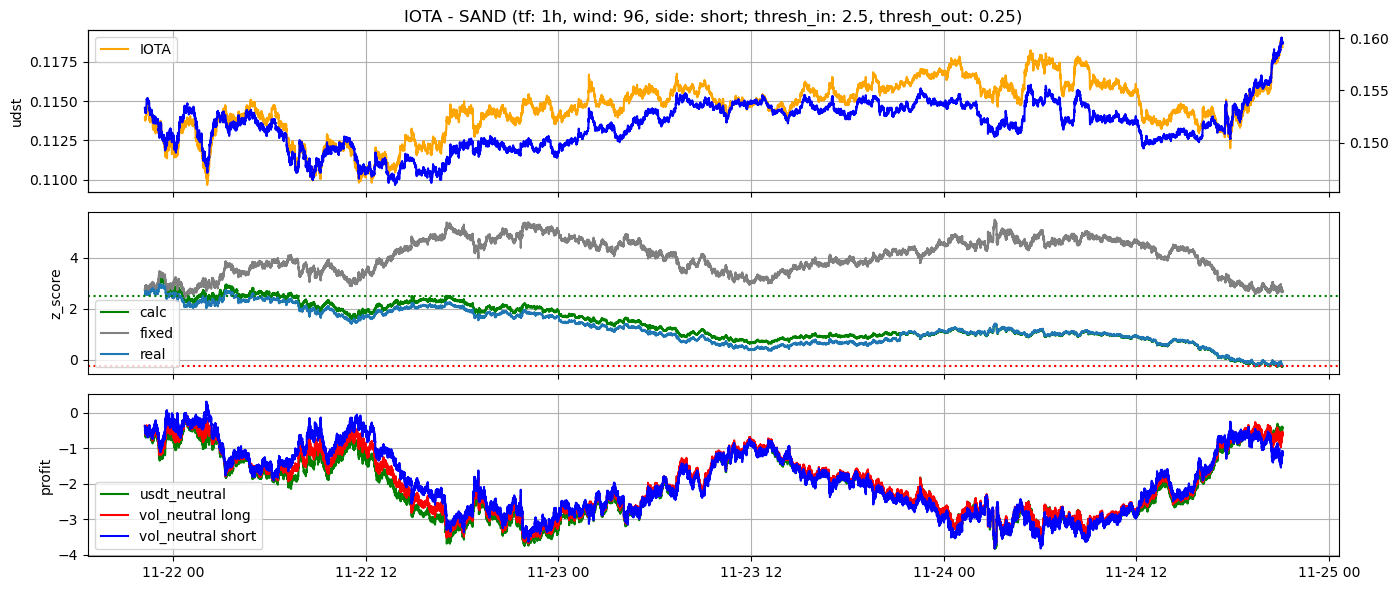

IOTA - SAND. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-21 22:14:31; Цены. IOTA: 0.1139; SAND: 0.1534; z_score: 2.55
Волатильность. (long): IOTA: 0.0435, SAND: 0.0464; (short): IOTA: 0.0013, SAND: 0.0016
std_ratio (long): 0.9377; std_ratio (short): 0.8183
Коэффициент хеджирования beta. beta_1: 1.406, beta_2: 0.666
Корреляция в предыдущие сутки: -0.99
Чувствительность в предыдущие сутки: Общая: -1.12; Pos: -1.11; Neg: -1.14
[CLOSE] Время: 2025-11-24 21:05:36; Цены. IOTA: 0.1185; SAND: 0.1595; z_score: -0.24
Corr. Usdt: -0.08; Vol-neut short: 0.12; Vol-neut long: -0.01
Чувствительность. Общая: -2.86; Pos: -2.95; Neg: -2.77

[PROFIT]
usdt-neutral     : 875.8 IOTA(short): -4.16$, 651.0 SAND(long): 3.74$; total profit: -0.42$
vol-neutral long : 904.1 IOTA(short): -4.27$, 629.0 SAND(long): 3.73$; total profit: -0.55$
vol-neutral short: 963.5 IOTA(short): -4.56$, 585.0 SAND(long): 3.47$; total profit: -1.09$
beta-neutral: 924.8 IOTA(short):

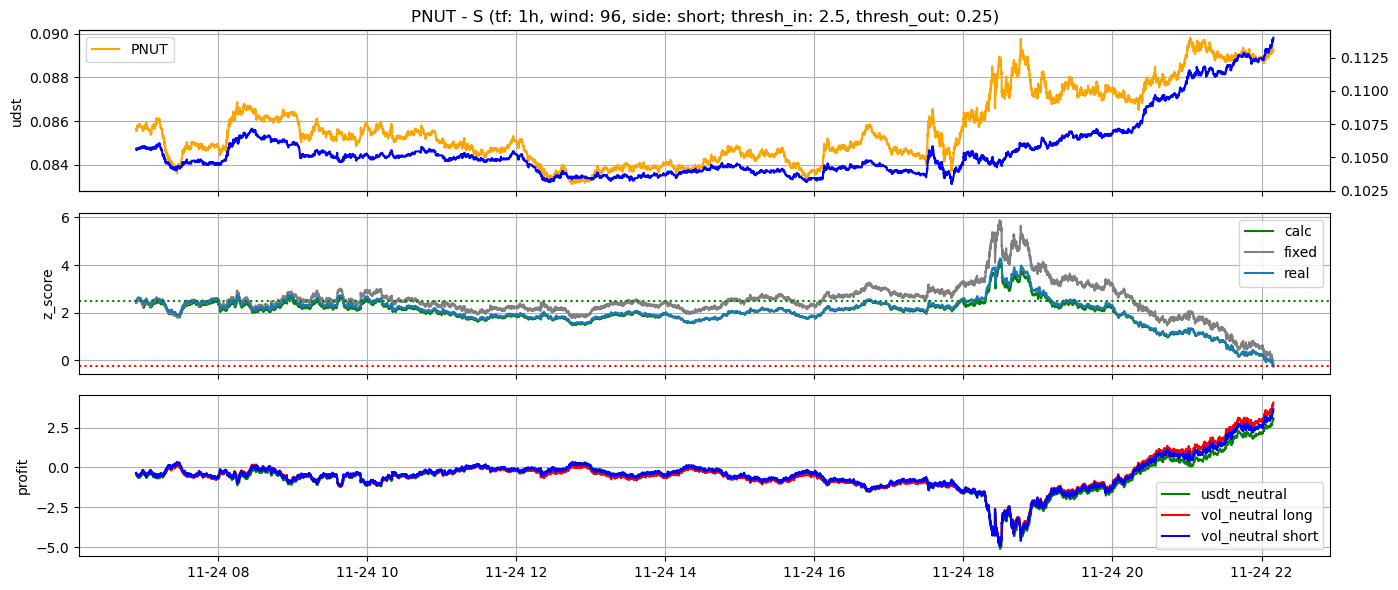

PNUT - S. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-24 06:54:05; Цены. PNUT: 0.08561; S: 0.1057; z_score: 2.50
Волатильность. (long): PNUT: 0.0674, S: 0.0587; (short): PNUT: 0.0012, S: 0.0011
std_ratio (long): 1.1476; std_ratio (short): 1.0692
Коэффициент хеджирования beta. beta_1: 1.304, beta_2: 0.715
Корреляция в предыдущие сутки: -1.00
Чувствительность в предыдущие сутки: Общая: -1.32; Pos: -1.43; Neg: -1.21
[CLOSE] Время: 2025-11-24 22:09:39; Цены. PNUT: 0.0892049; S: 0.11380254; z_score: -0.25
Corr. Usdt: -0.93; Vol-neut short: -0.95; Vol-neut long: -0.95
Чувствительность. Общая: -1.57; Pos: -1.79; Neg: -1.35

[PROFIT]
usdt-neutral     : 1165.0 PNUT(short): -4.37$, 945.0 S(long): 7.43$; total profit: 3.06$
vol-neutral long : 1085.0 PNUT(short): -4.00$, 1008.0 S(long): 8.05$; total profit: 4.04$
vol-neutral short: 1126.0 PNUT(short): -4.16$, 975.0 S(long): 7.78$; total profit: 3.63$
beta-neutral: 1240.0 PNUT(short): -4.58$, 886.

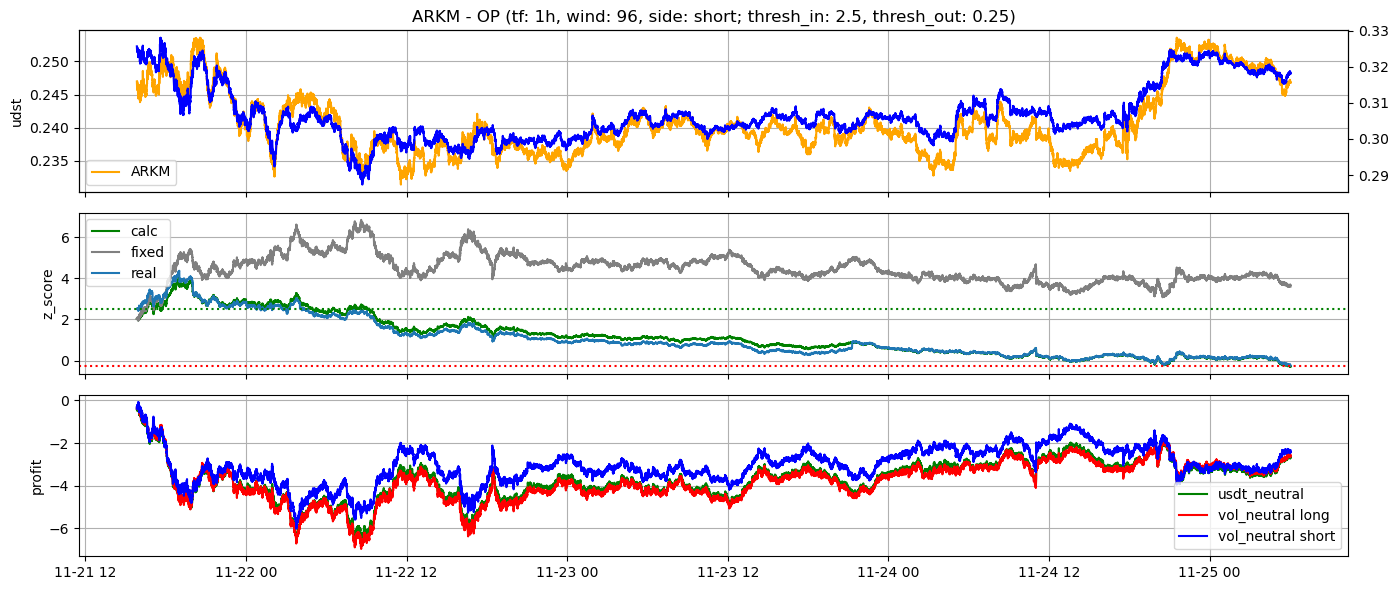

ARKM - OP. Side: short; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-21 15:50:50; Цены. ARKM: 0.2468; OP: 0.3256; z_score: 2.51
Волатильность. (long): ARKM: 0.0616, OP: 0.0581; (short): ARKM: 0.0038, OP: 0.0043
std_ratio (long): 1.0595; std_ratio (short): 0.8814
Коэффициент хеджирования beta. beta_1: 1.242, beta_2: 0.750
Корреляция в предыдущие сутки: -1.00
Чувствительность в предыдущие сутки: Общая: -1.29; Pos: -1.29; Neg: -1.30
[CLOSE] Время: 2025-11-25 06:02:11; Цены. ARKM: 0.247; OP: 0.3184; z_score: -0.25
Corr. Usdt: -0.56; Vol-neut short: -0.58; Vol-neut long: -0.53
Чувствительность. Общая: -3.51; Pos: -3.54; Neg: -3.48

[PROFIT]
usdt-neutral     : 404.0 ARKM(short): -0.36$, 305.7 OP(long): -2.42$; total profit: -2.78$
vol-neutral long : 390.0 ARKM(short): -0.18$, 313.7 OP(long): -2.37$; total profit: -2.55$
vol-neutral short: 427.0 ARKM(short): -0.20$, 285.7 OP(long): -2.16$; total profit: -2.36$
beta-neutral: 405.0 ARKM(short): -0.19$, 303.

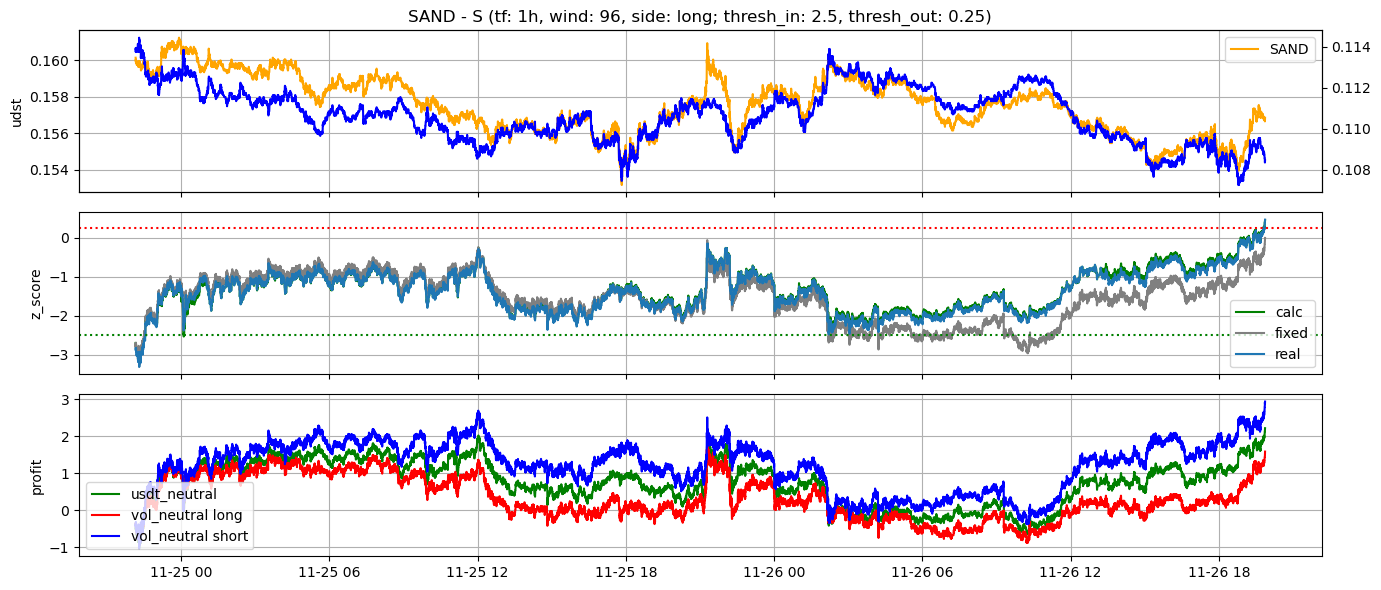

SAND - S. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-24 22:09:39; Цены. SAND: 0.1601; S: 0.1138; z_score: -2.84
Волатильность. (long): SAND: 0.0464, S: 0.0587; (short): SAND: 0.0013, S: 0.0011
std_ratio (long): 0.7906; std_ratio (short): 1.1875
Коэффициент хеджирования beta. beta_1: 1.665, beta_2: 0.482
Корреляция в предыдущие сутки: 1.00
Чувствительность в предыдущие сутки: Общая: 1.15; Pos: 1.10; Neg: 1.19
[CLOSE] Время: 2025-11-26 19:52:26; Цены. SAND: 0.1568; S: 0.1085; z_score: 0.47
Corr. Usdt: 0.83; Vol-neut short: 0.87; Vol-neut long: 0.65
Чувствительность. Общая: 1.18; Pos: 1.16; Neg: 1.20

[PROFIT]
usdt-neutral     : 622.0 SAND(long): -2.29$, 877.0 S(short): 4.51$; total profit: 2.22$
vol-neutral long : 692.0 SAND(long): -2.40$, 770.0 S(short): 3.99$; total profit: 1.58$
vol-neutral short: 566.0 SAND(long): -1.97$, 947.0 S(short): 4.90$; total profit: 2.94$
beta-neutral: 925.0 SAND(long): -3.21$, 445.0 S(short): 2.30$; total 

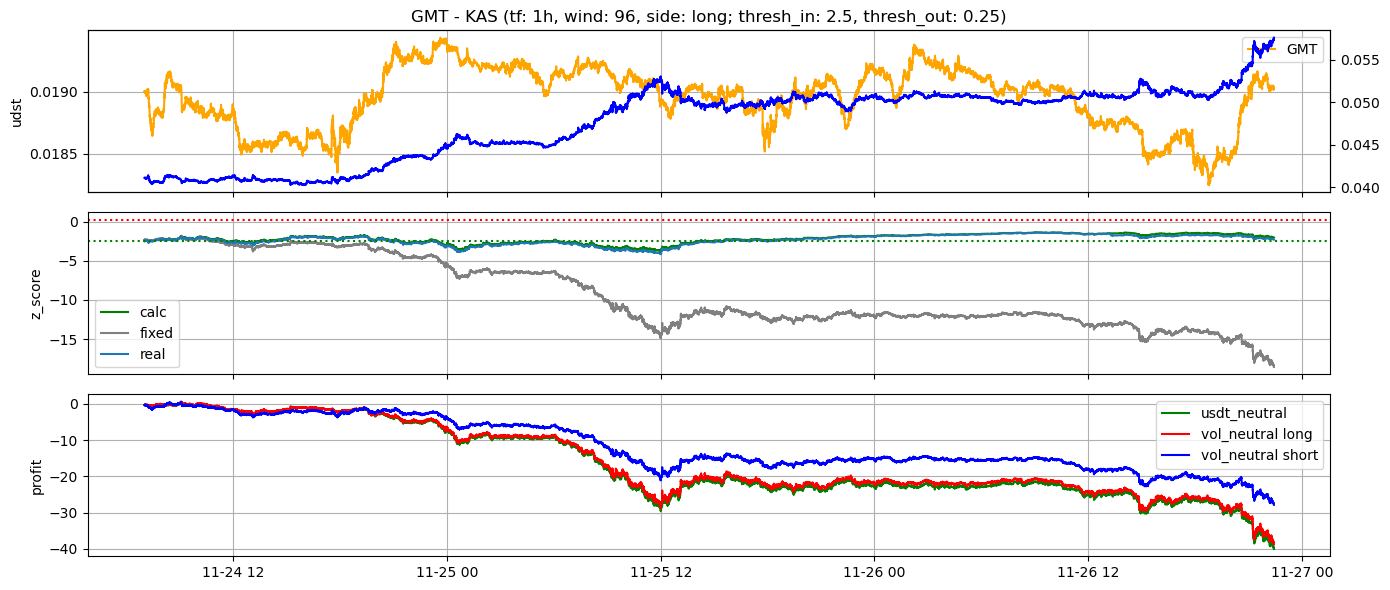

GMT - KAS. Side: long; Timeframe: 1h; window: 96; thresh_in: 2.5, thresh_out: 0.25
[ OPEN] Время: 2025-11-24 07:00:21; Цены. GMT: 0.01901; KAS: 0.04111; z_score: -2.50
Волатильность. (long): GMT: 0.0474, KAS: 0.0504; (short): GMT: 0.0002, KAS: 0.0004
std_ratio (long): 0.9398; std_ratio (short): 0.5338
Коэффициент хеджирования beta. beta_1: 1.515, beta_2: 0.580
Корреляция в предыдущие сутки: 0.98
Чувствительность в предыдущие сутки: Общая: 2.15; Pos: 1.97; Neg: 2.33
[CLOSE] Время: 2025-11-26 22:25:55; Цены. GMT: 0.01902; KAS: 0.05755; z_score: -2.30
Corr. Usdt: -0.33; Vol-neut short: -0.36; Vol-neut long: -0.33
Чувствительность. Общая: 10.32; Pos: 10.25; Neg: 10.39

[PROFIT]
usdt-neutral     : 5227.0 GMT(long): -0.22$, 2420.0 KAS(short): -40.01$; total profit: -40.23$
vol-neutral long : 5384.0 GMT(long): -0.06$, 2340.0 KAS(short): -38.60$; total profit: -38.66$
vol-neutral short: 6810.0 GMT(long): -0.07$, 1680.0 KAS(short): -27.71$; total profit: -27.78$
beta-neutral: 4639.0 GMT(long): 

In [30]:
tf = '1h'
wind = 96
thresh_in = 2.5
thresh_out = 0.25

profit_arr, profit_vnl_arr, profit_vns_arr, sl_arr, slf_arr, tp_arr  = [], [], [], [], [], []

for trade in trading_history.iter_rows(named=True):
    try:
        token_1 = trade['token_1']
        token_2 = trade['token_2']

        if token_1 == 'IOTA' and token_2 == 'CELO' or token_1 == 'MANTA' and token_2 == 'CELO':
            continue

        # if token_1 != 'ARKM' or token_2 != 'OP':
        #     continue
    
        open_time = trade['open_time']
        close_time = trade['close_time']
    
        profit, profit_vnl, profit_vns, sl_profit, slf_profit, tp_profit = create_report(token_1, token_2, tf, wind, thresh_in, thresh_out, 
                open_time, close_time, spread_method='dist',
                sl_usdt_ratio=0.1, sl_std=5.0, tp_ratio=0.2, fee_rate=0.00055, coin_information=coin_information,
                min_order=40)
        
        profit_arr.append(profit)
        profit_vnl_arr.append(profit_vnl)
        profit_vns_arr.append(profit_vns)
        
        if sl_profit:
            sl_arr.append(sl_profit)
        else:
            sl_arr.append(profit)

        if slf_profit:
            slf_arr.append(slf_profit)
        else:
            slf_arr.append(profit)

        if tp_profit:
            tp_arr.append(tp_profit)
        else:
            tp_arr.append(profit)
    except IndexError:
        print()
        print('========================================')
        print(f'Ошибка с парой {token_1} - {token_2}')
        print('========================================')
        print()

In [25]:
len(profit_arr)

25

In [27]:
np.sum(profit_arr), np.sum(profit_vnl_arr), np.sum(profit_vns_arr), np.sum(sl_arr), np.sum(slf_arr), np.sum(tp_arr)

(np.float64(-10.794081839999997),
 np.float64(-13.662098764180051),
 np.float64(3.243709734447723),
 np.float64(18.936041082500008),
 np.float64(-0.9575758946881159),
 np.float64(-10.794081839999997))

In [ ]:
np.mean(profit_arr), np.mean(profit_vnl_arr), np.mean(profit_vns_arr)

In [ ]:
np.std(profit_arr), np.std(profit_vnl_arr), np.std(profit_vns_arr)

In [ ]:
start_backtest_time = datetime(2025, 9, 14, 3, 28, 40, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 11, 24, 22, 40, tzinfo=ZoneInfo("Europe/Moscow"))

# metrics = analyze_strategy(trading_history, start_date=start_backtest_time, end_date=end_time, initial_balance=200.0)

In [ ]:
token_1 = 'GMT'
token_2 = 'KAS'
open_ts = 1763923060
close_ts = int(datetime.timestamp(datetime.now()))

z_score_hist = db_manager.get_zscore_history(token_1 + '_USDT', token_2 + '_USDT', open_ts, close_ts)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 3), sharex=True)
ax1.plot(z_score_hist['time'], z_score_hist['z_score'], c='blue', label='z_score')

ax2 = ax1.twinx()
ax2.plot(z_score_hist['time'], z_score_hist['profit'], c='green', label='profit')
fig.legend()
plt.grid()

In [ ]:
z_score_hist